## This notebook aims to visualize the different asset distributions produced by CGAN

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import sys
from tqdm import tqdm

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../../"))
sys.path.insert(0, parent_dir)

from utilities.gan_plotting import extensive_plotting
from utilities.backtesting_plots import backtest_var_single_asset
from utilities.gan_plotting import load_generated_returns
from backtesting.perform_var_tests import perform_var_backtesting_tests
from backtesting.perform_distribution_tests import perform_distribution_tests
from utilities.gan_plotting import create_rolling_empirical
from sklearn.preprocessing import StandardScaler

from dotenv.main import load_dotenv
load_dotenv(override=True)
import os


In [2]:
import os
print(os.getcwd())

c:\Users\nicka\master-thesis\internal_models\GANs\tuned_GANS


### Parameters

In [3]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = int(os.getenv("INIT_ASSETS")) * float(os.getenv("FRAC_LIABILITIES"))
num_simulations = int(os.getenv("N_SIMULATIONS"))
bof_0 = assets_0 - liabilities_0

## Note to self -- We only test assets MSCIWORLD, HY and EONIA

In [4]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [3, 6]#[0,1,2,4]
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:400]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [5]:
asset_names = returns_df.columns

num_assets = returns_df.shape[1]
weights = np.full(num_assets, 1 / num_assets)  

## TRAINING CGAN

In [6]:
def plot_generated_scenarios(scenarios, title="Generated Scenarios", num_samples=10):
    """
    Plot a sample of generated scenarios.
    
    Parameters:
      scenarios (np.array): Array of shape (num_scenarios, window_size) with generated return sequences.
      title (str): Title for the plot.
      num_samples (int): Number of scenarios to randomly sample and plot.
    """
    # Sample a few scenarios to avoid overcrowding the plot.
    sample_indices = np.random.choice(scenarios.shape[0], size=min(num_samples, scenarios.shape[0]), replace=False)
    sampled_scenarios = scenarios[sample_indices, :]
    
    plt.figure(figsize=(12, 6))
    for scenario in sampled_scenarios:
        plt.plot(scenario, alpha=0.7)
    plt.title(title)
    plt.xlabel("Days")
    plt.ylabel("Returns")
    plt.grid(True)
    plt.show()

def plot_generated_distribution(scenarios, title="Distribution of Cumulative Returns", bins=500):
    """
    Plot the distribution of cumulative returns computed from the generated scenarios.
    
    Parameters:
      scenarios (np.array): Array of shape (num_scenarios, window_size) with generated return sequences.
      title (str): Title for the plot.
      bins (int): Number of bins for the histogram.
    """
    # Compute cumulative returns for each scenario.
    cumulative_returns = np.array([np.prod(1 + scenario) - 1 for scenario in scenarios])
    
    plt.figure(figsize=(10, 6))
    plt.hist(cumulative_returns, bins=bins, density=True, alpha=0.6, color='b')
    plt.title(title)
    plt.xlabel("Cumulative Return")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()


In [7]:
from OliviaGAN import OliviaGAN
from MarketGAN import MarketGAN
from FashionGAN import FashionGAN

gan_dict = {}

# Dictionary to store generated scenarios by asset and date.
# Structure: { asset_name: { date: generated_scenarios, ... }, ... }
scenarios_results = {}

for asset_name in tqdm(returns_df.columns, desc="Training GANs", unit="asset"):
    print(f"Training GAN for {asset_name}...")
    asset_returns = returns_df[asset_name]
    
    gan = FashionGAN(asset_returns, asset_name)
    gan.train()
    print(f"Finished training GAN for {asset_name}.\n")
    
    scenarios = gan.generate_scenarios(num_scenarios=10000)
    print(f"Finished generating scenarios for {asset_name}.\n")
    
    gan_dict[asset_name] = gan

    initial_date = returns_df.index[-1]
    scenarios_results.setdefault(asset_name, {})[initial_date] = scenarios
    print(f"{asset_name}: Stored initial generated scenarios for {initial_date}.")

Training GANs:   0%|          | 0/2 [00:00<?, ?asset/s]

Training GAN for IG...
[Epoch 0/600] [Batch 0/27] [D loss: 1.4252] [G loss: 81.4677] [Tail penalty: 0.9462] [Structure penalty: 0.9806]
[Epoch 0/600] [Batch 10/27] [D loss: 0.6062] [G loss: 56.9033] [Tail penalty: 0.6500] [Structure penalty: 0.7066]
[Epoch 0/600] [Batch 20/27] [D loss: 0.5040] [G loss: 36.5571] [Tail penalty: 0.4451] [Structure penalty: 0.4016]
[Epoch 1/600] [Batch 0/27] [D loss: 0.7231] [G loss: 22.0172] [Tail penalty: 0.2577] [Structure penalty: 0.2608]
[Epoch 1/600] [Batch 10/27] [D loss: 0.7595] [G loss: 11.7149] [Tail penalty: 0.1236] [Structure penalty: 0.1611]
[Epoch 1/600] [Batch 20/27] [D loss: 0.6367] [G loss: 7.7189] [Tail penalty: 0.0515] [Structure penalty: 0.1638]
[Epoch 2/600] [Batch 0/27] [D loss: 0.6809] [G loss: 7.1410] [Tail penalty: 0.0277] [Structure penalty: 0.1859]
[Epoch 2/600] [Batch 10/27] [D loss: 0.4845] [G loss: 7.3201] [Tail penalty: 0.0067] [Structure penalty: 0.2305]
[Epoch 2/600] [Batch 20/27] [D loss: 0.3789] [G loss: 8.0026] [Tail pen

Training GANs:  50%|█████     | 1/2 [15:46<15:46, 946.77s/asset]

Finished training GAN for IG.

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_IG_final_scenarios.pt
Finished generating scenarios for IG.

IG: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for EONIA...
[Epoch 0/600] [Batch 0/27] [D loss: 24.4493] [G loss: 1098.4091] [Tail penalty: 1.7952] [Structure penalty: 33.3189]
[Epoch 0/600] [Batch 10/27] [D loss: 8.7358] [G loss: 743.1144] [Tail penalty: 1.4392] [Structure penalty: 22.1284]
[Epoch 0/600] [Batch 20/27] [D loss: 6.7615] [G loss: 371.1414] [Tail penalty: 1.1563] [Structure penalty: 10.2477]
[Epoch 1/600] [Batch 0/27] [D loss: 3.0760] [G loss: 163.8833] [Tail penalty: 0.9352] [Structure penalty: 3.7466]
[Epoch 1/600] [Batch 10/27] [D loss: 2.7843] [G loss: 68.0868] [Tail penalty: 0.7486] [Structure penalty: 0.8968]
[Epoch 1/600] [Batch 20/27] [D loss: 2.6609] [G loss: 50.0162] [Tail penalty: 0.6369] [Structure penalty: 0.4972]
[Epoch 2/600] [Batch 0/27] [D loss: 1.7002] [G loss:

Training GANs: 100%|██████████| 2/2 [31:45<00:00, 952.88s/asset]

Finished training GAN for EONIA.

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_EONIA_final_scenarios.pt
Finished generating scenarios for EONIA.

EONIA: Stored initial generated scenarios for 2019-12-31 00:00:00.


In [131]:
for asset_name in tqdm(test_returns_df.columns, desc="Updating GANs", unit="asset"):
    asset_returns = returns_df[asset_name]
    gan = gan_dict[asset_name]
    foundNAN = False
    for test_day in test_returns_df.index:
        new_return = test_returns_df.loc[test_day, asset_name]
        new_row = pd.DataFrame({asset_name: [new_return]}, index=[test_day])
        asset_returns = pd.concat([asset_returns, new_row])
        
        print("date", test_day)

        # test different lookbacks
        scenarios = gan.generate_new_scenarios_from_return(new_return, test_day, 63, save=False, num_scenarios=10000)

        # plot_generated_distribution(scenarios=scenarios)
        has_inf = np.isinf(scenarios).any()
        has_nan = np.isnan(scenarios).any()

        if has_nan or has_inf:
            print("FOUND NAN")
            foundNAN = True
            break

        print(f"{asset_name}: Generated new distribution on {test_day}.")

        scenarios_results.setdefault(asset_name, {})[test_day] = scenarios
        
        print(f"{asset_name}: Stored generated scenarios for {test_day}.")
    
    if foundNAN: break

Updating GANs:   0%|          | 0/2 [00:00<?, ?asset/s]

date 2020-01-02 00:00:00
IG: Generated new distribution on 2020-01-02 00:00:00.
IG: Stored generated scenarios for 2020-01-02 00:00:00.
date 2020-01-03 00:00:00
IG: Generated new distribution on 2020-01-03 00:00:00.
IG: Stored generated scenarios for 2020-01-03 00:00:00.
date 2020-01-06 00:00:00
IG: Generated new distribution on 2020-01-06 00:00:00.
IG: Stored generated scenarios for 2020-01-06 00:00:00.
date 2020-01-07 00:00:00
IG: Generated new distribution on 2020-01-07 00:00:00.
IG: Stored generated scenarios for 2020-01-07 00:00:00.
date 2020-01-08 00:00:00
IG: Generated new distribution on 2020-01-08 00:00:00.
IG: Stored generated scenarios for 2020-01-08 00:00:00.
date 2020-01-09 00:00:00
IG: Generated new distribution on 2020-01-09 00:00:00.
IG: Stored generated scenarios for 2020-01-09 00:00:00.
date 2020-01-10 00:00:00
IG: Generated new distribution on 2020-01-10 00:00:00.
IG: Stored generated scenarios for 2020-01-10 00:00:00.
date 2020-01-13 00:00:00
IG: Generated new distr

Updating GANs:   0%|          | 0/2 [09:49<?, ?asset/s]


KeyboardInterrupt: 

In [ ]:
returns_df.tail()

IG     EONIA
Date                          
2019-12-23 -0.000395 -0.000045
2019-12-24  0.001135 -0.000015
2019-12-27  0.001971 -0.000015
2019-12-30 -0.001701 -0.000045
2019-12-31 -0.000746 -0.000015

In [ ]:
from internal_models.multivariate_GAN.simple_gan_portfolio import SimpleGANPortfolio
from internal_models.multivariate_GAN.students_copula_GAN import StudentCopula

## We need to get rolling Delta BOF

In [ ]:
entire_df = pd.concat([returns_df, test_returns_df])

entire_df.tail()

IG     EONIA
Date                          
2021-07-21 -0.002522 -0.000016
2021-07-22  0.001797 -0.000016
2021-07-23 -0.000580 -0.000016
2021-07-26  0.000473 -0.000047
2021-07-27  0.001789 -0.000016

In [ ]:
test_start_date = test_returns_df.index.min()
test_end_date = test_returns_df.index.max()
print("Test end date:", test_end_date)

# Find the index location of the test_start_date in entire_df
idx = entire_df.index.get_loc(test_end_date)
idx_start = entire_df.index.get_loc(test_start_date)

# Slice 252 rows before that index
historical_df = entire_df.iloc[idx_start - 252:]
historical_df.head()

Test end date: 2021-07-27 00:00:00


IG    EONIA
Date                         
2019-01-03  0.003209 -0.00001
2019-01-04 -0.004488 -0.00001
2019-01-07  0.000024 -0.00003
2019-01-08 -0.000592 -0.00001
2019-01-09  0.001019 -0.00001

In [ ]:
historical_df.tail()

IG     EONIA
Date                          
2021-07-21 -0.002522 -0.000016
2021-07-22  0.001797 -0.000016
2021-07-23 -0.000580 -0.000016
2021-07-26  0.000473 -0.000047
2021-07-27  0.001789 -0.000016

In [ ]:
entire_df.tail()

IG     EONIA
Date                          
2021-07-21 -0.002522 -0.000016
2021-07-22  0.001797 -0.000016
2021-07-23 -0.000580 -0.000016
2021-07-26  0.000473 -0.000047
2021-07-27  0.001789 -0.000016

# CASE 1

- We first calculate realized delta BOF for a given window

In [ ]:
# CALCULATE DELTA BOF ARRAY
eonia = historical_df.iloc[:, -1]
bof_0 = assets_0 - liabilities_0

portfolio_returns = (historical_df * weights).sum(axis=1)

portfolio_value = assets_0 * (1 + portfolio_returns).cumprod()

liabilities = liabilities_0 * (1 + eonia).cumprod()

bof = portfolio_value - liabilities

daily_delta_bof = bof.diff().fillna(0)


rolling_delta_bof = daily_delta_bof.rolling(window=252).sum()


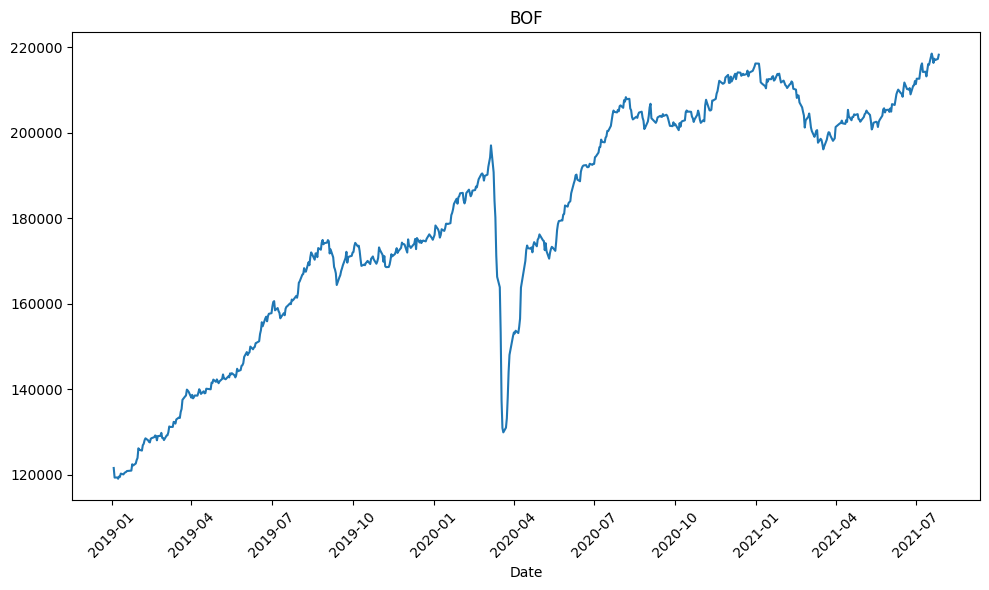

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(bof.index, bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("BOF")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

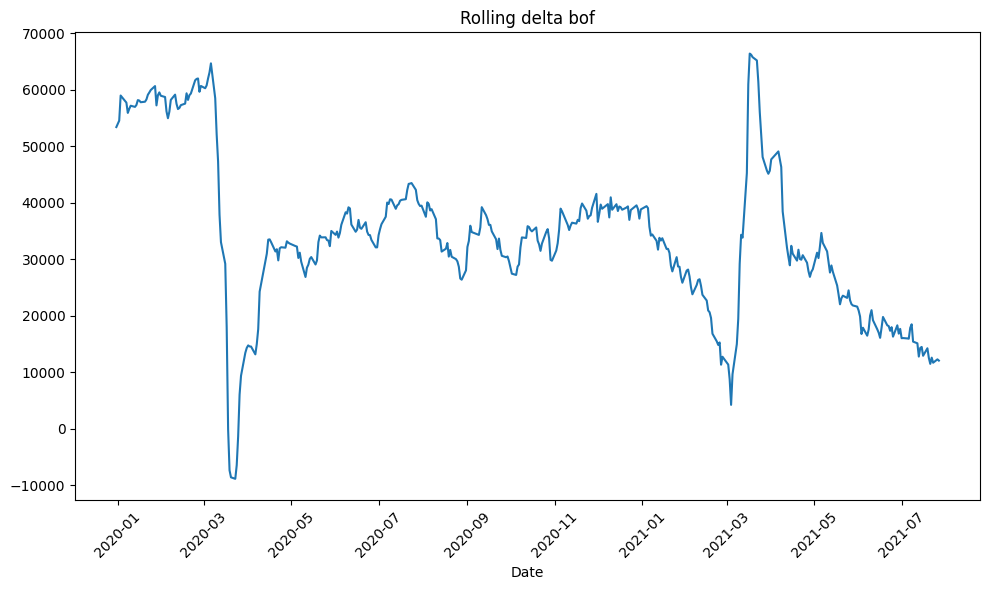

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(rolling_delta_bof.index, rolling_delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("Rolling delta bof")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

# Case 2

Same, assuming constant BOF0

In [ ]:
bof.loc["2019-12-31"]

np.float64(174967.82065186684)

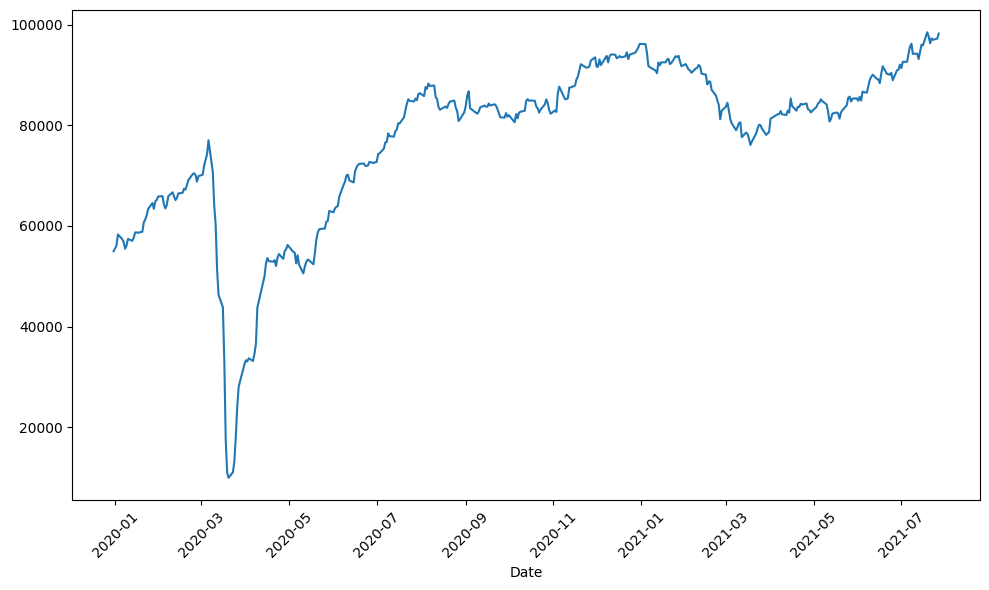

In [ ]:
bof_case_ii = bof.loc["2019-12-31":]

delta_bof_case_ii = bof_case_ii - bof_0

plt.figure(figsize=(10, 6))
plt.plot(delta_bof_case_ii.index, delta_bof_case_ii.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

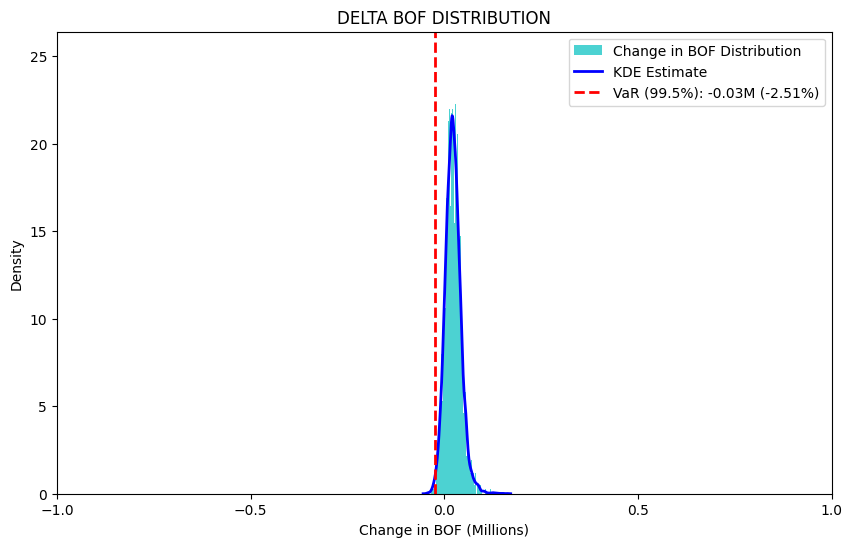

Date 2019-12-31 00:00:00: SCR = -25066.35433241844
Date 2020-01-02 00:00:00: SCR = -21842.509669780728
Date 2020-01-03 00:00:00: SCR = -23397.628786878573
Date 2020-01-06 00:00:00: SCR = -23391.178090991965
Date 2020-01-07 00:00:00: SCR = -21910.94397500037
Date 2020-01-08 00:00:00: SCR = -20849.004483747478
Date 2020-01-09 00:00:00: SCR = -22068.267607212067
Date 2020-01-10 00:00:00: SCR = -22242.71719434738
Date 2020-01-13 00:00:00: SCR = -22620.714079198828
Date 2020-01-14 00:00:00: SCR = -23577.75093558311
Date 2020-01-15 00:00:00: SCR = -22346.857698497766
Date 2020-01-16 00:00:00: SCR = -22194.970958280563
Date 2020-01-17 00:00:00: SCR = -22140.86535378456
Date 2020-01-20 00:00:00: SCR = -22323.521726055144
Date 2020-01-21 00:00:00: SCR = -21187.802555027007
Date 2020-01-22 00:00:00: SCR = -22845.03598294258
Date 2020-01-23 00:00:00: SCR = -21339.00537167549
Date 2020-01-24 00:00:00: SCR = -22124.563049135206
Date 2020-01-27 00:00:00: SCR = -23499.235178203584


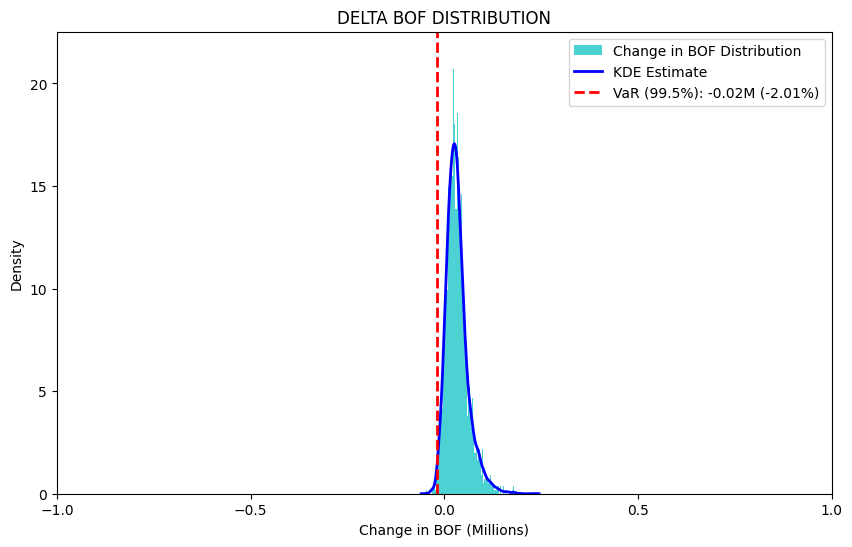

Date 2020-01-28 00:00:00: SCR = -20099.764170684808
Date 2020-01-29 00:00:00: SCR = -24158.722751665115
Date 2020-01-30 00:00:00: SCR = -22325.04868117332
Date 2020-01-31 00:00:00: SCR = -23190.316997137066
Date 2020-02-03 00:00:00: SCR = -22029.984857778538
Date 2020-02-04 00:00:00: SCR = -21601.688893451683
Date 2020-02-05 00:00:00: SCR = -20309.03392580985
Date 2020-02-06 00:00:00: SCR = -21700.934523220058
Date 2020-02-07 00:00:00: SCR = -22833.08306284904
Date 2020-02-10 00:00:00: SCR = -21465.31787197113
Date 2020-02-11 00:00:00: SCR = -22634.879222507472
Date 2020-02-12 00:00:00: SCR = -23550.45835111618
Date 2020-02-13 00:00:00: SCR = -23534.98903177261
Date 2020-02-14 00:00:00: SCR = -23685.89151273726
Date 2020-02-17 00:00:00: SCR = -22417.66037664413
Date 2020-02-18 00:00:00: SCR = -21598.50681671142
Date 2020-02-19 00:00:00: SCR = -23333.758834371565
Date 2020-02-20 00:00:00: SCR = -22304.134231643675
Date 2020-02-21 00:00:00: SCR = -21328.727067747113
Date 2020-02-24 00:00

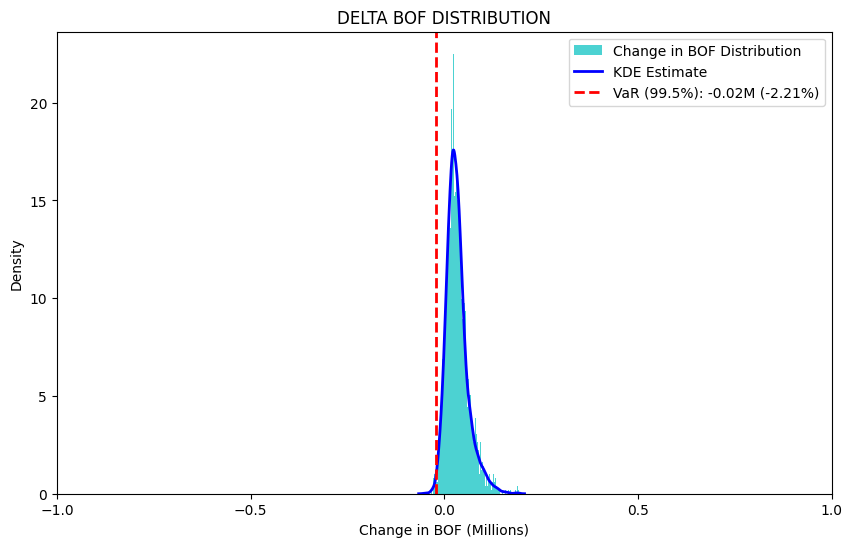

Date 2020-02-25 00:00:00: SCR = -22079.094767475126
Date 2020-02-26 00:00:00: SCR = -22762.886195611947
Date 2020-02-27 00:00:00: SCR = -23182.06794293403
Date 2020-02-28 00:00:00: SCR = -21718.705218687053
Date 2020-03-02 00:00:00: SCR = -22024.761673088073
Date 2020-03-03 00:00:00: SCR = -22082.636723928434
Date 2020-03-04 00:00:00: SCR = -21331.04674512863
Date 2020-03-05 00:00:00: SCR = -23061.449477014532
Date 2020-03-06 00:00:00: SCR = -22447.095642538065
Date 2020-03-09 00:00:00: SCR = -21302.927594785677
Date 2020-03-10 00:00:00: SCR = -20635.002079315178
Date 2020-03-11 00:00:00: SCR = -22608.532490768423
Date 2020-03-12 00:00:00: SCR = -21685.1421010971
Date 2020-03-13 00:00:00: SCR = -22421.38751478195
Date 2020-03-16 00:00:00: SCR = -22516.287338075625
Date 2020-03-17 00:00:00: SCR = -21421.105116701117
Date 2020-03-18 00:00:00: SCR = -21593.0930462265
Date 2020-03-19 00:00:00: SCR = -22843.367635364528
Date 2020-03-20 00:00:00: SCR = -22214.67503847122
Date 2020-03-23 00:0

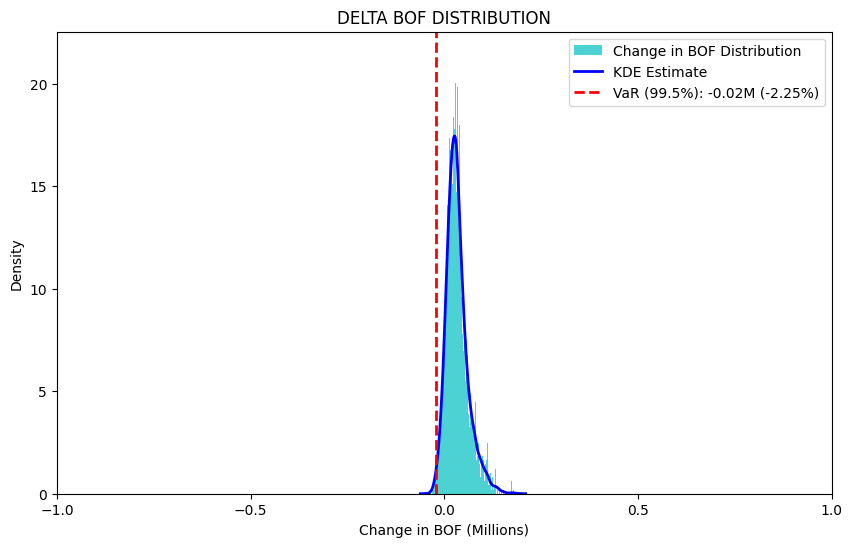

Date 2020-03-24 00:00:00: SCR = -22496.336021604537
Date 2020-03-25 00:00:00: SCR = -23399.059853067392
Date 2020-03-26 00:00:00: SCR = -22367.796346445073
Date 2020-03-27 00:00:00: SCR = -22669.011561088555
Date 2020-03-30 00:00:00: SCR = -21838.55713335037
Date 2020-03-31 00:00:00: SCR = -20999.794966220852
Date 2020-04-01 00:00:00: SCR = -21996.100608777997
Date 2020-04-02 00:00:00: SCR = -23077.39610554695
Date 2020-04-03 00:00:00: SCR = -23744.65364150047
Date 2020-04-06 00:00:00: SCR = -22475.77075302124
Date 2020-04-07 00:00:00: SCR = -22088.998881464002
Date 2020-04-08 00:00:00: SCR = -22261.798772220605
Date 2020-04-09 00:00:00: SCR = -22349.934405679698
Date 2020-04-14 00:00:00: SCR = -21203.350521574015
Date 2020-04-15 00:00:00: SCR = -20649.69593549727
Date 2020-04-16 00:00:00: SCR = -21108.642996873852
Date 2020-04-17 00:00:00: SCR = -21063.85821537971
Date 2020-04-20 00:00:00: SCR = -23253.79559447288
Date 2020-04-21 00:00:00: SCR = -22622.87060760498
Date 2020-04-22 00:0

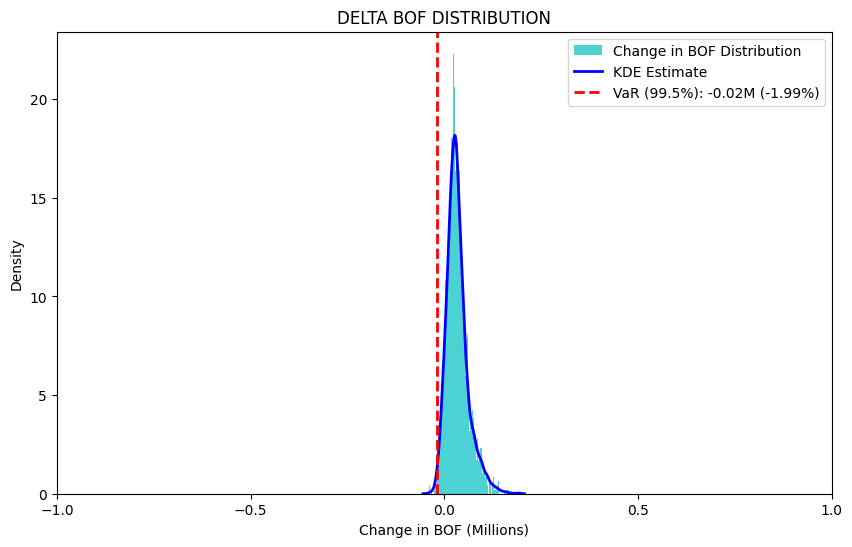

Date 2020-04-23 00:00:00: SCR = -19885.39000427246
Date 2020-04-24 00:00:00: SCR = -21564.675580654144
Date 2020-04-27 00:00:00: SCR = -22859.91749103546
Date 2020-04-28 00:00:00: SCR = -21218.57666282652
Date 2020-04-29 00:00:00: SCR = -21991.10462792396
Date 2020-04-30 00:00:00: SCR = -21758.372974901195
Date 2020-05-04 00:00:00: SCR = -22592.706651926037
Date 2020-05-05 00:00:00: SCR = -21642.50810344696
Date 2020-05-06 00:00:00: SCR = -22135.116496686933
Date 2020-05-07 00:00:00: SCR = -21698.04538064956
Date 2020-05-08 00:00:00: SCR = -21327.729749174116
Date 2020-05-11 00:00:00: SCR = -20147.287693529117
Date 2020-05-12 00:00:00: SCR = -22117.813806066482
Date 2020-05-13 00:00:00: SCR = -21044.47206956862
Date 2020-05-14 00:00:00: SCR = -21732.776942319866
Date 2020-05-15 00:00:00: SCR = -21039.74232796669
Date 2020-05-18 00:00:00: SCR = -23209.66377518653
Date 2020-05-19 00:00:00: SCR = -22687.419921636578
Date 2020-05-20 00:00:00: SCR = -22658.09727305412
Date 2020-05-21 00:00:

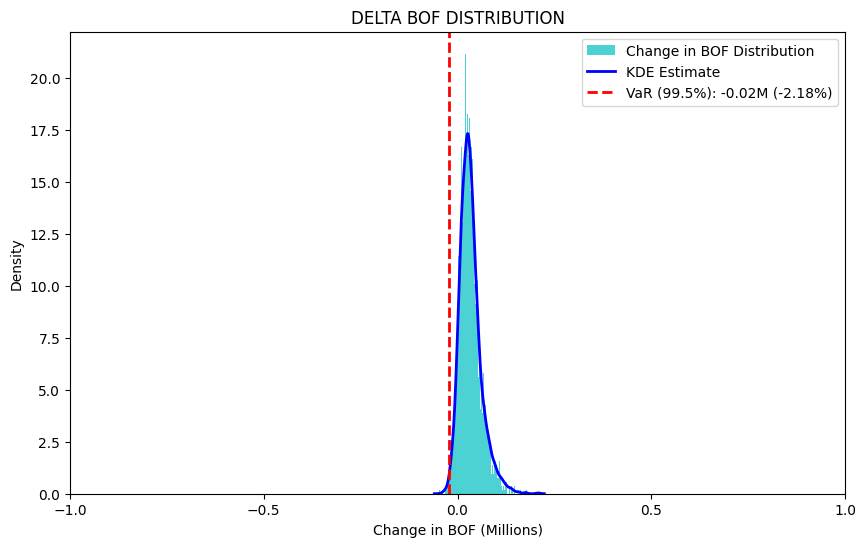

Date 2020-05-22 00:00:00: SCR = -21798.528496284478
Date 2020-05-25 00:00:00: SCR = -21588.59802389144
Date 2020-05-26 00:00:00: SCR = -22521.16828809738
Date 2020-05-27 00:00:00: SCR = -20738.211396160117
Date 2020-05-28 00:00:00: SCR = -22329.83920737266
Date 2020-05-29 00:00:00: SCR = -21590.144657974226
Date 2020-06-01 00:00:00: SCR = -22432.800717859267
Date 2020-06-02 00:00:00: SCR = -21816.209603853218
Date 2020-06-03 00:00:00: SCR = -21570.429824552524
Date 2020-06-04 00:00:00: SCR = -22424.76819674491
Date 2020-06-05 00:00:00: SCR = -22314.81081224441
Date 2020-06-08 00:00:00: SCR = -20479.46114101409
Date 2020-06-09 00:00:00: SCR = -22368.274259757993
Date 2020-06-10 00:00:00: SCR = -23649.429969196317
Date 2020-06-11 00:00:00: SCR = -22301.951749124524
Date 2020-06-12 00:00:00: SCR = -21373.468440513607
Date 2020-06-15 00:00:00: SCR = -21201.424754829404
Date 2020-06-16 00:00:00: SCR = -22403.349076137525
Date 2020-06-17 00:00:00: SCR = -21858.192996864316
Date 2020-06-18 00

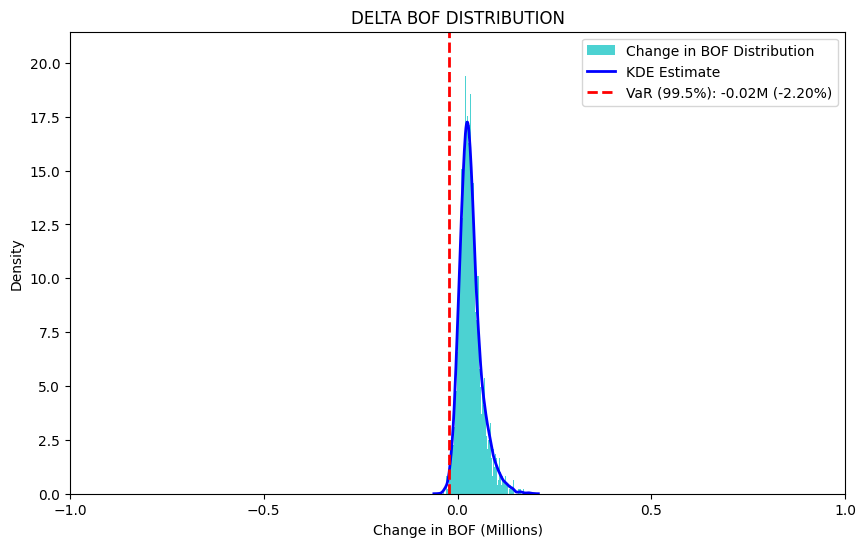

Date 2020-06-19 00:00:00: SCR = -21995.713031826013
Date 2020-06-22 00:00:00: SCR = -22024.13314666747
Date 2020-06-23 00:00:00: SCR = -21129.069343290317
Date 2020-06-24 00:00:00: SCR = -21334.036540603618
Date 2020-06-25 00:00:00: SCR = -21627.28979237555
Date 2020-06-26 00:00:00: SCR = -21407.924217271804
Date 2020-06-29 00:00:00: SCR = -20972.76866792677
Date 2020-06-30 00:00:00: SCR = -21543.627704210277
Date 2020-07-01 00:00:00: SCR = -21955.82937255859
Date 2020-07-02 00:00:00: SCR = -22870.66333230972
Date 2020-07-03 00:00:00: SCR = -20209.10645296096
Date 2020-07-06 00:00:00: SCR = -23403.19228281021
Date 2020-07-07 00:00:00: SCR = -20468.701212120028
Date 2020-07-08 00:00:00: SCR = -21696.88864224434
Date 2020-07-09 00:00:00: SCR = -21182.572981758112
Date 2020-07-10 00:00:00: SCR = -21610.263081102366
Date 2020-07-13 00:00:00: SCR = -20014.052083692543
Date 2020-07-14 00:00:00: SCR = -22877.31506314277
Date 2020-07-15 00:00:00: SCR = -22109.352469902034
Date 2020-07-16 00:00

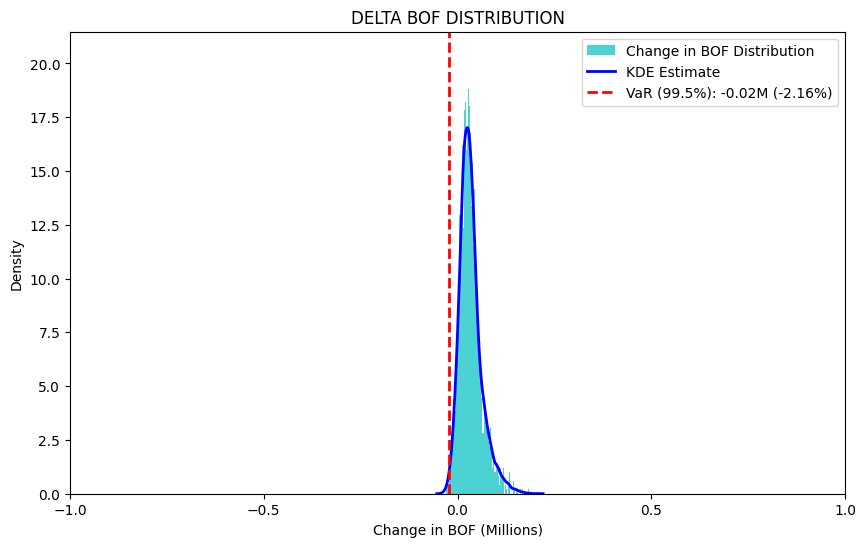

Date 2020-07-17 00:00:00: SCR = -21612.237104911805
Date 2020-07-20 00:00:00: SCR = -22885.782040576934
Date 2020-07-21 00:00:00: SCR = -21591.039929456707
Date 2020-07-22 00:00:00: SCR = -22529.5505341339
Date 2020-07-23 00:00:00: SCR = -21769.200552406302
Date 2020-07-24 00:00:00: SCR = -22961.82018271445
Date 2020-07-27 00:00:00: SCR = -21812.701456251136
Date 2020-07-28 00:00:00: SCR = -20919.48982618332
Date 2020-07-29 00:00:00: SCR = -20103.514016666406
Date 2020-07-30 00:00:00: SCR = -22747.416464262005
Date 2020-07-31 00:00:00: SCR = -22351.353154144286
Date 2020-08-03 00:00:00: SCR = -21098.819163980483
Date 2020-08-04 00:00:00: SCR = -22891.853684177397
Date 2020-08-05 00:00:00: SCR = -21385.194952592847
Date 2020-08-06 00:00:00: SCR = -22535.033059883117
Date 2020-08-07 00:00:00: SCR = -22071.525968790047
Date 2020-08-10 00:00:00: SCR = -22900.80448266028
Date 2020-08-11 00:00:00: SCR = -21636.04833357809
Date 2020-08-12 00:00:00: SCR = -21834.392071638107
Date 2020-08-13 00

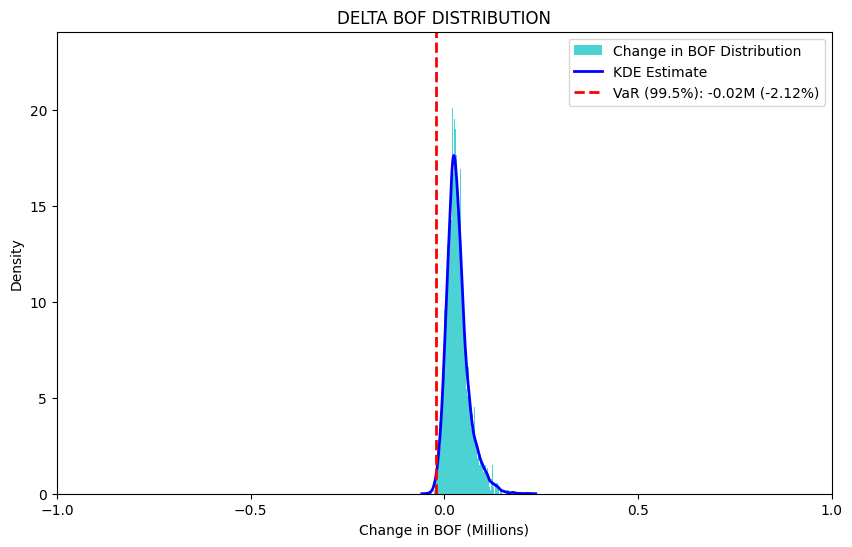

Date 2020-08-14 00:00:00: SCR = -21225.894652023315
Date 2020-08-17 00:00:00: SCR = -21726.393814296716
Date 2020-08-18 00:00:00: SCR = -21968.57036877631
Date 2020-08-19 00:00:00: SCR = -21918.23594244957
Date 2020-08-20 00:00:00: SCR = -21778.36411948204
Date 2020-08-21 00:00:00: SCR = -20790.91071045874
Date 2020-08-24 00:00:00: SCR = -20919.768463764183
Date 2020-08-25 00:00:00: SCR = -20505.90054918289
Date 2020-08-26 00:00:00: SCR = -22174.61739643096
Date 2020-08-27 00:00:00: SCR = -20616.683507852555
Date 2020-08-28 00:00:00: SCR = -23563.86074810028
Date 2020-08-31 00:00:00: SCR = -21625.712539253236
Date 2020-09-01 00:00:00: SCR = -22705.868539314262
Date 2020-09-02 00:00:00: SCR = -21392.325490045547
Date 2020-09-03 00:00:00: SCR = -21580.303362722396
Date 2020-09-04 00:00:00: SCR = -22824.309765491485
Date 2020-09-09 00:00:00: SCR = -22320.387128000253
Date 2020-09-10 00:00:00: SCR = -21530.499805746073
Date 2020-09-11 00:00:00: SCR = -22026.0867098236
Date 2020-09-14 00:00

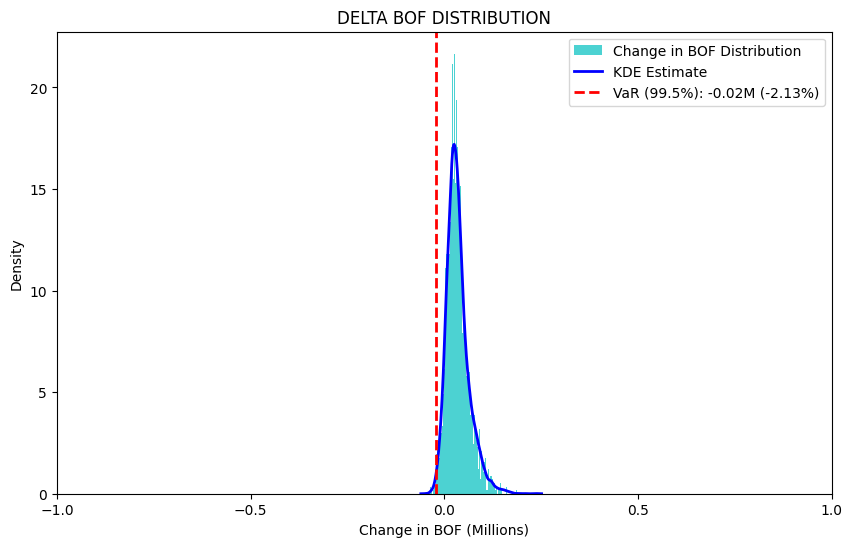

Date 2020-09-15 00:00:00: SCR = -21321.26146711349
Date 2020-09-16 00:00:00: SCR = -21073.044520349496
Date 2020-09-17 00:00:00: SCR = -21781.65202135086
Date 2020-09-18 00:00:00: SCR = -24114.70799713134
Date 2020-09-21 00:00:00: SCR = -22428.338424835198
Date 2020-09-22 00:00:00: SCR = -21880.74937680244
Date 2020-09-23 00:00:00: SCR = -21538.19180020331
Date 2020-09-24 00:00:00: SCR = -22134.282084093094
Date 2020-09-25 00:00:00: SCR = -21876.038685789095
Date 2020-09-28 00:00:00: SCR = -21068.244038753506
Date 2020-09-29 00:00:00: SCR = -21771.620238952633
Date 2020-09-30 00:00:00: SCR = -21855.89208786964
Date 2020-10-01 00:00:00: SCR = -21041.815604658124
Date 2020-10-02 00:00:00: SCR = -21344.11310399055
Date 2020-10-05 00:00:00: SCR = -21796.8023441696
Date 2020-10-06 00:00:00: SCR = -21592.07670381545
Date 2020-10-07 00:00:00: SCR = -21266.21768433571
Date 2020-10-08 00:00:00: SCR = -21576.086654901494
Date 2020-10-09 00:00:00: SCR = -20514.8747564125
Date 2020-10-12 00:00:00:

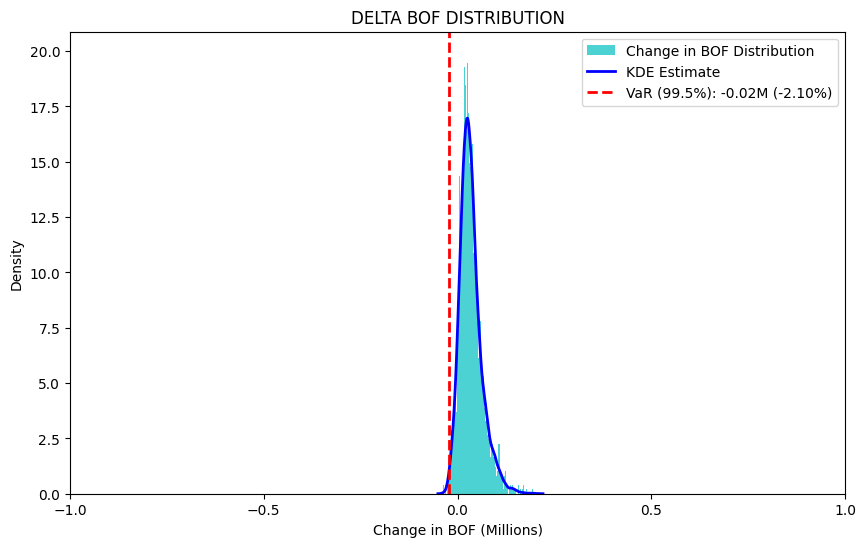

Date 2020-10-13 00:00:00: SCR = -20950.44074030876
Date 2020-10-14 00:00:00: SCR = -21790.867598114008
Date 2020-10-15 00:00:00: SCR = -22945.213456468566
Date 2020-10-16 00:00:00: SCR = -20242.964192457188
Date 2020-10-19 00:00:00: SCR = -21639.183383960724
Date 2020-10-20 00:00:00: SCR = -20734.50597854612
Date 2020-10-21 00:00:00: SCR = -21666.636762313843
Date 2020-10-22 00:00:00: SCR = -22019.948303918838
Date 2020-10-23 00:00:00: SCR = -21322.343122406004
Date 2020-10-26 00:00:00: SCR = -22992.96781066894
Date 2020-10-27 00:00:00: SCR = -21414.742960777283
Date 2020-10-28 00:00:00: SCR = -21559.149199409483
Date 2020-10-29 00:00:00: SCR = -21292.877701225272
Date 2020-10-30 00:00:00: SCR = -22713.542850713708
Date 2020-11-02 00:00:00: SCR = -21178.819205512995
Date 2020-11-03 00:00:00: SCR = -23425.979619178765
Date 2020-11-04 00:00:00: SCR = -21449.274035825725
Date 2020-11-05 00:00:00: SCR = -20314.905054759976
Date 2020-11-06 00:00:00: SCR = -21839.824490995397
Date 2020-11-09

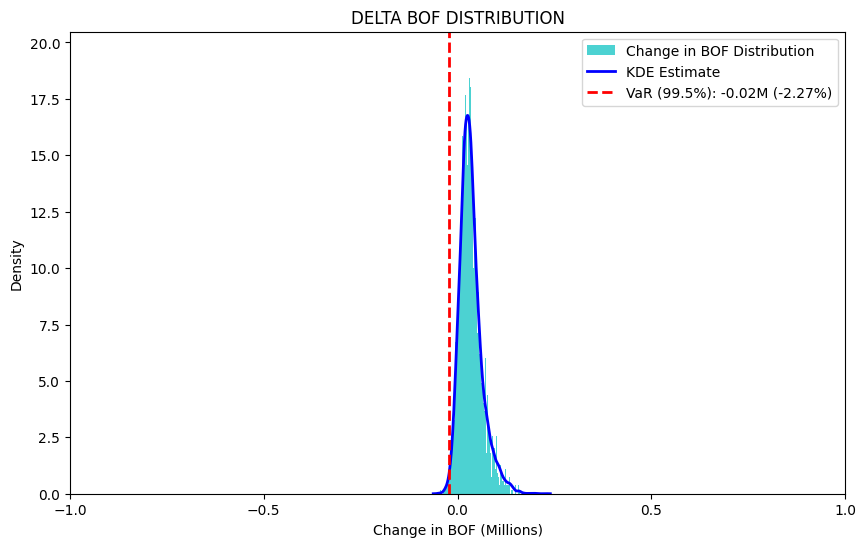

Date 2020-11-10 00:00:00: SCR = -22673.925878791808
Date 2020-11-11 00:00:00: SCR = -22633.348009481422
Date 2020-11-12 00:00:00: SCR = -21732.06613250732
Date 2020-11-13 00:00:00: SCR = -22252.511405506124
Date 2020-11-16 00:00:00: SCR = -22103.293866529446
Date 2020-11-17 00:00:00: SCR = -22449.830484542832
Date 2020-11-18 00:00:00: SCR = -21771.15061450958
Date 2020-11-19 00:00:00: SCR = -21877.058443574893
Date 2020-11-20 00:00:00: SCR = -20144.026636991486
Date 2020-11-23 00:00:00: SCR = -21292.25799696922
Date 2020-11-24 00:00:00: SCR = -22851.923779897686
Date 2020-11-25 00:00:00: SCR = -21371.832624673836
Date 2020-11-26 00:00:00: SCR = -22486.37608416557
Date 2020-11-27 00:00:00: SCR = -20951.48681159019
Date 2020-11-30 00:00:00: SCR = -22663.461752901076
Date 2020-12-01 00:00:00: SCR = -22718.516308116905
Date 2020-12-02 00:00:00: SCR = -21699.058697862623
Date 2020-12-03 00:00:00: SCR = -21778.657970199583
Date 2020-12-04 00:00:00: SCR = -22170.290998105997
Date 2020-12-07 0

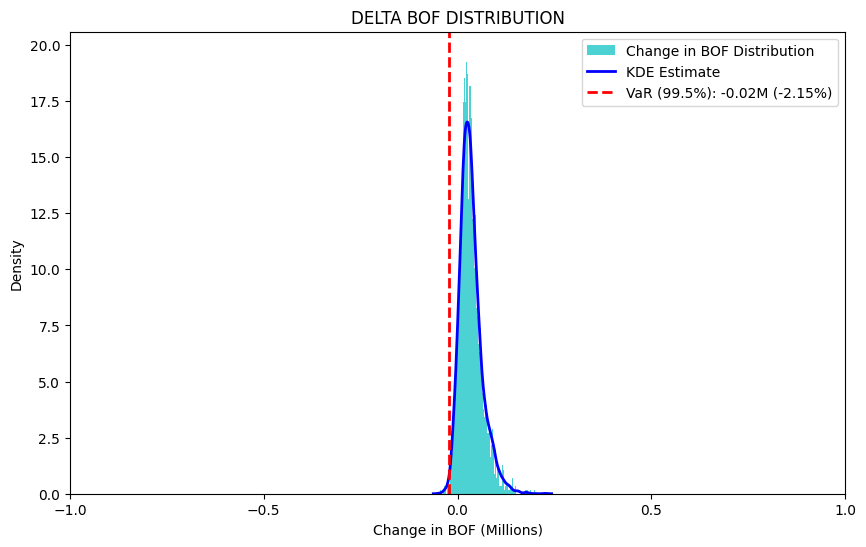

Date 2020-12-08 00:00:00: SCR = -21463.367303600306
Date 2020-12-09 00:00:00: SCR = -20880.67627025604
Date 2020-12-10 00:00:00: SCR = -21889.632364206314
Date 2020-12-11 00:00:00: SCR = -22189.16926429748
Date 2020-12-14 00:00:00: SCR = -21775.438588705063
Date 2020-12-15 00:00:00: SCR = -22295.672926111198
Date 2020-12-16 00:00:00: SCR = -21474.64304242134
Date 2020-12-17 00:00:00: SCR = -22616.12718025207
Date 2020-12-18 00:00:00: SCR = -20268.56251938819
Date 2020-12-21 00:00:00: SCR = -20779.170582256316
Date 2020-12-22 00:00:00: SCR = -22988.61269915581
Date 2020-12-23 00:00:00: SCR = -20993.945400962828
Date 2020-12-24 00:00:00: SCR = -21697.798003120417
Date 2020-12-28 00:00:00: SCR = -20851.714500026683
Date 2020-12-29 00:00:00: SCR = -21054.837126007078
Date 2020-12-30 00:00:00: SCR = -20818.361207914346
Date 2020-12-31 00:00:00: SCR = -19966.048203697203
Date 2021-01-04 00:00:00: SCR = -21629.667680177678
Date 2021-01-05 00:00:00: SCR = -21740.6362195301
Date 2021-01-06 00:0

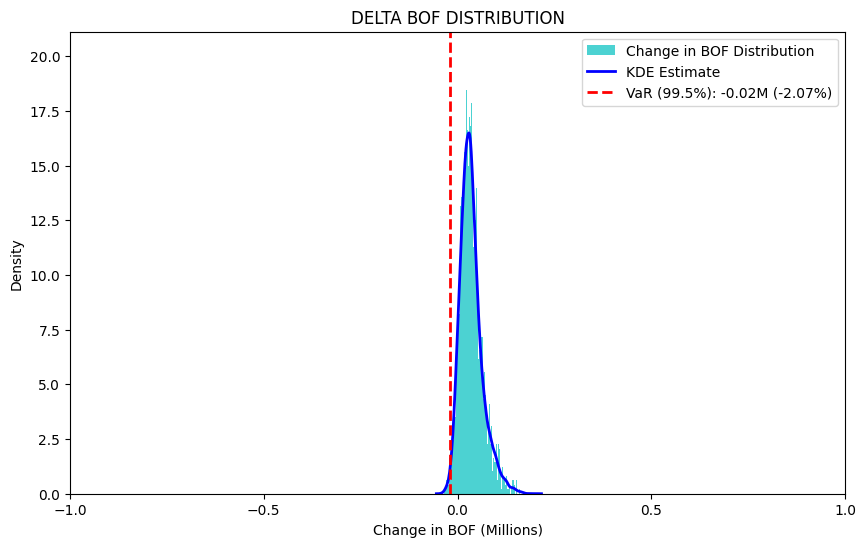

Date 2021-01-07 00:00:00: SCR = -20701.488739814755
Date 2021-01-08 00:00:00: SCR = -21819.022608900053
Date 2021-01-11 00:00:00: SCR = -21312.052409782398
Date 2021-01-12 00:00:00: SCR = -20742.085027608868
Date 2021-01-13 00:00:00: SCR = -22229.62658436775
Date 2021-01-14 00:00:00: SCR = -20736.26440987587
Date 2021-01-15 00:00:00: SCR = -21993.758660936346
Date 2021-01-18 00:00:00: SCR = -21428.915771198266
Date 2021-01-19 00:00:00: SCR = -22939.71790927886
Date 2021-01-20 00:00:00: SCR = -21099.996426582333
Date 2021-01-21 00:00:00: SCR = -21776.865330009456
Date 2021-01-22 00:00:00: SCR = -22304.707983798977
Date 2021-01-25 00:00:00: SCR = -21899.00158082008
Date 2021-01-26 00:00:00: SCR = -21331.402942199704
Date 2021-01-27 00:00:00: SCR = -21208.96695092201
Date 2021-01-28 00:00:00: SCR = -21719.599401149742
Date 2021-01-29 00:00:00: SCR = -21506.950659666054
Date 2021-02-01 00:00:00: SCR = -21795.144471216197
Date 2021-02-02 00:00:00: SCR = -23048.49142770767
Date 2021-02-03 00

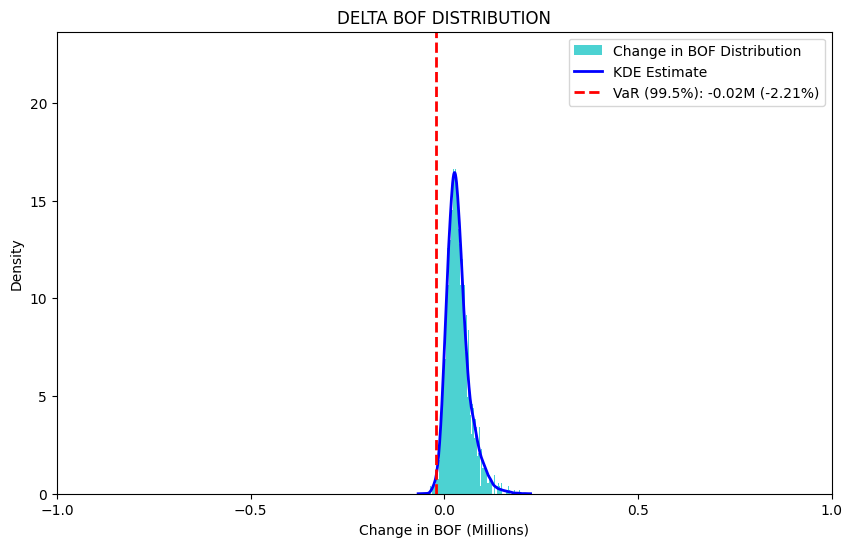

Date 2021-02-04 00:00:00: SCR = -22128.467218151087
Date 2021-02-05 00:00:00: SCR = -21566.144510631555
Date 2021-02-08 00:00:00: SCR = -21180.527753524766
Date 2021-02-09 00:00:00: SCR = -22166.48491688728
Date 2021-02-10 00:00:00: SCR = -24133.10194933891
Date 2021-02-11 00:00:00: SCR = -23581.423269462575
Date 2021-02-12 00:00:00: SCR = -23303.817643337246
Date 2021-02-15 00:00:00: SCR = -21280.687916250223
Date 2021-02-16 00:00:00: SCR = -22082.27739813804
Date 2021-02-17 00:00:00: SCR = -20345.64296900749
Date 2021-02-18 00:00:00: SCR = -21925.14120147705
Date 2021-02-19 00:00:00: SCR = -22231.217380113594
Date 2021-02-22 00:00:00: SCR = -22356.237424917217
Date 2021-02-23 00:00:00: SCR = -20329.19541582107
Date 2021-02-24 00:00:00: SCR = -22267.60835458755
Date 2021-02-25 00:00:00: SCR = -21375.025536766047
Date 2021-02-26 00:00:00: SCR = -23198.23302439689
Date 2021-03-01 00:00:00: SCR = -23915.60439281463
Date 2021-03-02 00:00:00: SCR = -21700.120905303953
Date 2021-03-03 00:00

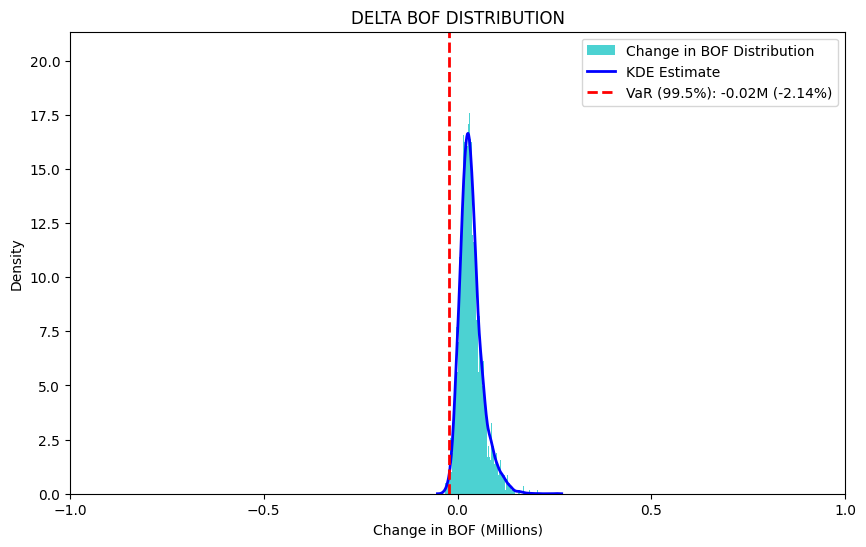

Date 2021-03-04 00:00:00: SCR = -21378.102215490337
Date 2021-03-05 00:00:00: SCR = -23398.620886697765
Date 2021-03-08 00:00:00: SCR = -21513.592039937965
Date 2021-03-09 00:00:00: SCR = -21245.711373558042
Date 2021-03-10 00:00:00: SCR = -22193.013472337723
Date 2021-03-11 00:00:00: SCR = -21499.577356109618
Date 2021-03-12 00:00:00: SCR = -21587.04082586288
Date 2021-03-15 00:00:00: SCR = -21429.105151262283
Date 2021-03-16 00:00:00: SCR = -21064.308348932267
Date 2021-03-17 00:00:00: SCR = -22671.124301099775
Date 2021-03-18 00:00:00: SCR = -20519.14810135841
Date 2021-03-19 00:00:00: SCR = -21494.587196378703
Date 2021-03-22 00:00:00: SCR = -21896.34127043723
Date 2021-03-23 00:00:00: SCR = -22002.95812421798
Date 2021-03-24 00:00:00: SCR = -19597.077998685825
Date 2021-03-25 00:00:00: SCR = -21128.6174223423
Date 2021-03-26 00:00:00: SCR = -20711.365499801635
Date 2021-03-29 00:00:00: SCR = -21791.1003394699
Date 2021-03-30 00:00:00: SCR = -21361.786956548684
Date 2021-03-31 00:0

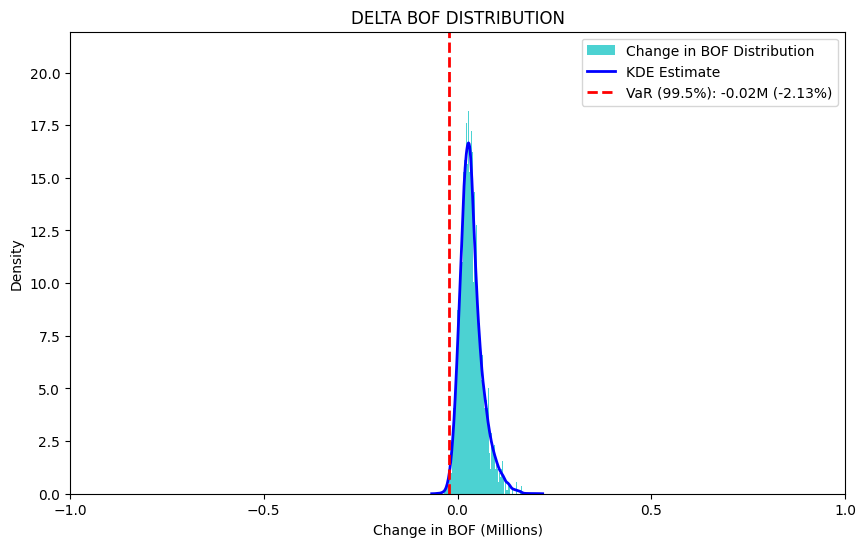

Date 2021-04-01 00:00:00: SCR = -21311.41809626579
Date 2021-04-06 00:00:00: SCR = -23308.050434026714
Date 2021-04-07 00:00:00: SCR = -22793.44310159683
Date 2021-04-08 00:00:00: SCR = -21593.06825956344
Date 2021-04-09 00:00:00: SCR = -21019.59884651184
Date 2021-04-12 00:00:00: SCR = -20615.793817043297
Date 2021-04-13 00:00:00: SCR = -22226.932145252224
Date 2021-04-14 00:00:00: SCR = -21122.643788614256
Date 2021-04-15 00:00:00: SCR = -21708.09145179747
Date 2021-04-16 00:00:00: SCR = -22461.12138330458
Date 2021-04-19 00:00:00: SCR = -22451.985382719035
Date 2021-04-20 00:00:00: SCR = -21880.962012939446
Date 2021-04-21 00:00:00: SCR = -22320.710651512138
Date 2021-04-22 00:00:00: SCR = -22660.83932925224
Date 2021-04-23 00:00:00: SCR = -21652.664143419264
Date 2021-04-26 00:00:00: SCR = -21102.933924589157
Date 2021-04-27 00:00:00: SCR = -21252.16029193878
Date 2021-04-28 00:00:00: SCR = -21955.275904216764
Date 2021-04-29 00:00:00: SCR = -21445.65479935646
Date 2021-04-30 00:00

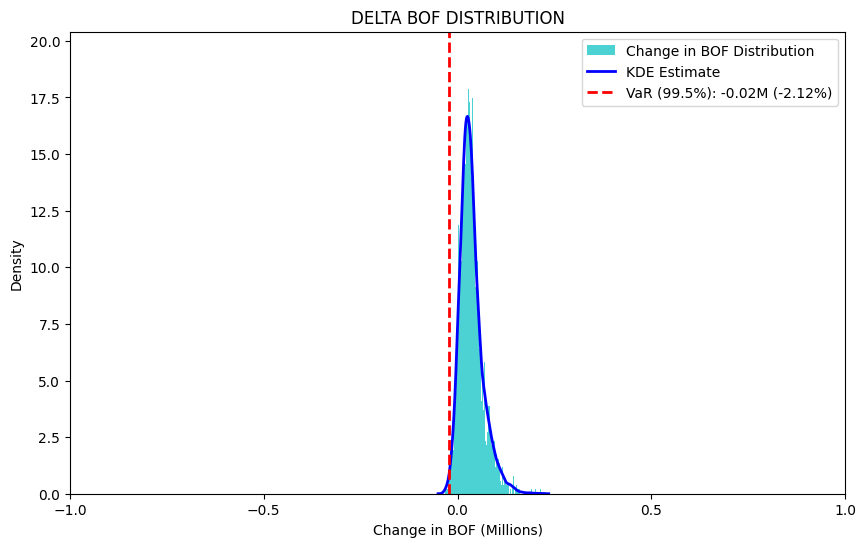

Date 2021-05-03 00:00:00: SCR = -21231.112685422882
Date 2021-05-04 00:00:00: SCR = -21096.504886541366
Date 2021-05-05 00:00:00: SCR = -20414.30375928879
Date 2021-05-06 00:00:00: SCR = -22982.157642116545
Date 2021-05-07 00:00:00: SCR = -23506.5298446846
Date 2021-05-10 00:00:00: SCR = -23421.183152408594
Date 2021-05-11 00:00:00: SCR = -20836.272534198757
Date 2021-05-12 00:00:00: SCR = -22202.06456663131
Date 2021-05-13 00:00:00: SCR = -22197.53369256973
Date 2021-05-14 00:00:00: SCR = -21428.663150777815
Date 2021-05-17 00:00:00: SCR = -20288.204197683313
Date 2021-05-18 00:00:00: SCR = -23066.555715789793
Date 2021-05-19 00:00:00: SCR = -21081.777719163892
Date 2021-05-20 00:00:00: SCR = -22715.38947974205
Date 2021-05-21 00:00:00: SCR = -23029.949395027154
Date 2021-05-24 00:00:00: SCR = -21429.277607526776
Date 2021-05-25 00:00:00: SCR = -20279.149895868297
Date 2021-05-26 00:00:00: SCR = -22989.869056777952
Date 2021-05-27 00:00:00: SCR = -23541.56625041008
Date 2021-05-28 00:

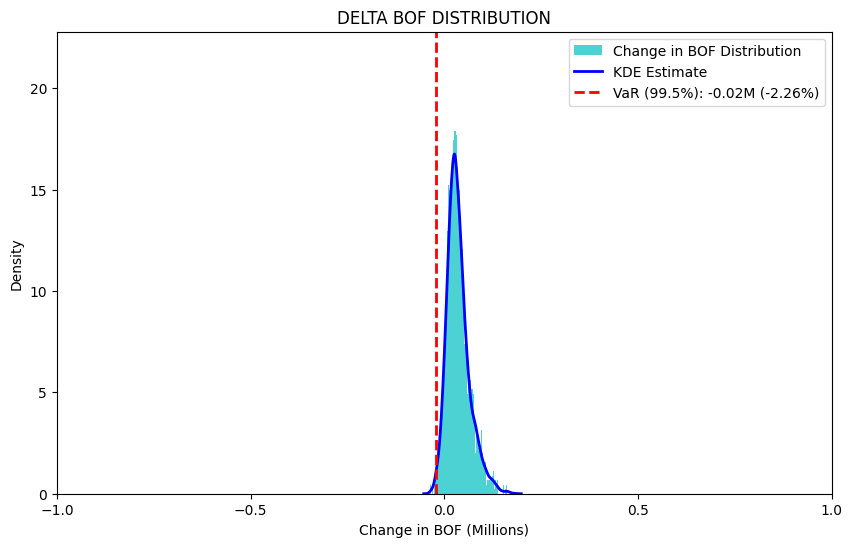

Date 2021-05-31 00:00:00: SCR = -22566.372772054667
Date 2021-06-01 00:00:00: SCR = -22291.7896610546
Date 2021-06-02 00:00:00: SCR = -21408.15600420951
Date 2021-06-03 00:00:00: SCR = -21635.121112995148
Date 2021-06-04 00:00:00: SCR = -22123.900600872035
Date 2021-06-07 00:00:00: SCR = -21805.53536408423
Date 2021-06-08 00:00:00: SCR = -21684.744640016554
Date 2021-06-09 00:00:00: SCR = -20506.512489290235
Date 2021-06-10 00:00:00: SCR = -21881.723291683196
Date 2021-06-11 00:00:00: SCR = -22695.473441658018
Date 2021-06-14 00:00:00: SCR = -20742.450120363235
Date 2021-06-15 00:00:00: SCR = -22197.79848475456
Date 2021-06-16 00:00:00: SCR = -21872.898706121443
Date 2021-06-17 00:00:00: SCR = -20098.784502267834
Date 2021-06-18 00:00:00: SCR = -23070.73415250778
Date 2021-06-21 00:00:00: SCR = -20543.876320619584
Date 2021-06-22 00:00:00: SCR = -22883.111402006132
Date 2021-06-23 00:00:00: SCR = -21671.065314645755
Date 2021-06-24 00:00:00: SCR = -21946.89372611046
Date 2021-06-25 00:

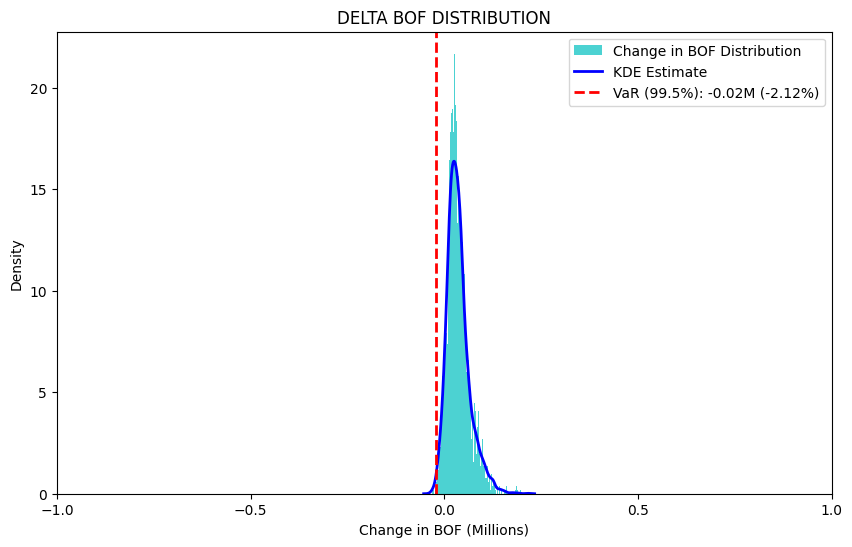

Date 2021-06-28 00:00:00: SCR = -21197.7306862545
Date 2021-06-29 00:00:00: SCR = -22335.451538763034
Date 2021-06-30 00:00:00: SCR = -21690.02147404669
Date 2021-07-01 00:00:00: SCR = -23057.576276159285
Date 2021-07-02 00:00:00: SCR = -20470.566414566038
Date 2021-07-05 00:00:00: SCR = -22470.532886743542
Date 2021-07-06 00:00:00: SCR = -20900.65108105659
Date 2021-07-07 00:00:00: SCR = -21256.61465355872
Date 2021-07-08 00:00:00: SCR = -21231.16447075843
Date 2021-07-09 00:00:00: SCR = -21656.00118336677
Date 2021-07-12 00:00:00: SCR = -21655.388963985442
Date 2021-07-13 00:00:00: SCR = -21692.726982498156
Date 2021-07-14 00:00:00: SCR = -21680.199876661285
Date 2021-07-15 00:00:00: SCR = -21600.739516172405
Date 2021-07-16 00:00:00: SCR = -21611.964250221245
Date 2021-07-19 00:00:00: SCR = -21389.059701623915
Date 2021-07-20 00:00:00: SCR = -19863.475713205335
Date 2021-07-21 00:00:00: SCR = -21078.9468494606
Date 2021-07-22 00:00:00: SCR = -22100.50779604911
Date 2021-07-23 00:00:

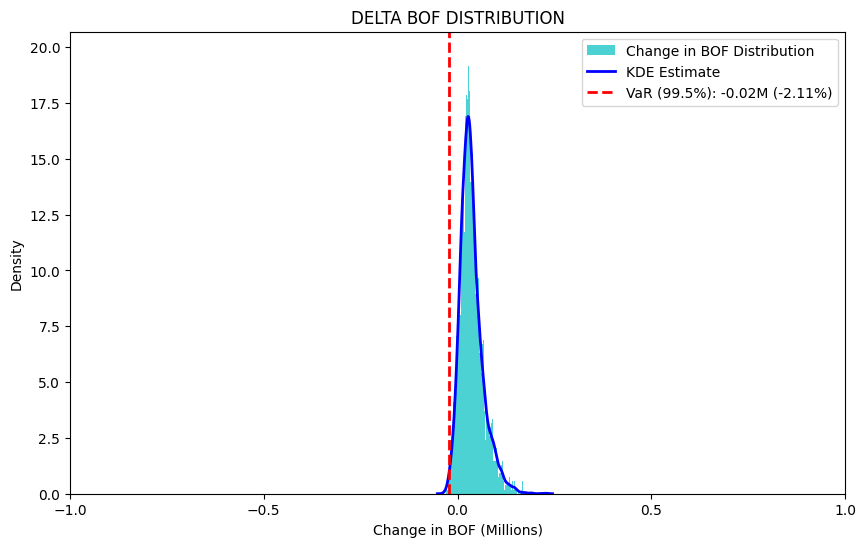

Date 2021-07-26 00:00:00: SCR = -21069.976573047636
Date 2021-07-27 00:00:00: SCR = -20974.865558614725


In [ ]:
asset_names = list(returns_df.columns)

from utilities.bof_var_plot import plot_bof_var

# scenarios_results is assumed to be a nested dictionary:
# { asset_name: { date: scenarios_array, ... }, ... }
# where scenarios_array has shape (n_simulations, window_size)
#
# We want to build a matrix for each date of shape (n_simulations, n_assets),
# where each column is the last value (i.e. cumulative return) from the corresponding asset’s scenarios.

# Get the list of dates for which we have generated scenarios.
# (Assuming the dates are the same across assets, here we take the dates from the first asset.)
all_dates = sorted(list(scenarios_results[asset_names[0]].keys()))

# Dictionary to store SCR for each date.
portfolio_scr_results = {}  # key: date, value: scr

i = 0
for date in all_dates[:]:
    i += 1
    gan_samples_cols = []
    for asset in asset_names:
        # Retrieve the scenarios for the asset at this date.
        asset_scenarios = scenarios_results[asset][date]  # expected shape: (n_simulations, window_size)
        # Use the last column to represent the cumulative return.
        asset_cum = np.prod(1 + asset_scenarios, axis=1) - 1
        if np.isnan(asset_cum).any() or np.isinf(asset_cum).any():
            print(f"Warning: NaN or Inf encountered in cumulative returns for asset {asset} on date {date}.")
        gan_samples_cols.append(asset_cum.reshape(-1, 1))

    # Stack horizontally so that each column corresponds to one asset.
    gan_samples = np.hstack(gan_samples_cols)  # shape: (n_simulations, n_assets)
    
    # Create a portfolio with the aggregated GAN samples and the specified weights.

    bof_0_case_i = bof.iloc[bof.index.get_loc(date) - 252]

    portfolio = SimpleGANPortfolio(gan_samples, weights, bof0_casei=bof_0_case_i)
    bof_change, scr = portfolio.calculate_distribution_and_scr(case=2)

    if i % 20 == 0 or i == 1:
        plot_bof_var(bof_change,scr,"DELTA BOF DISTRIBUTION")
    
    portfolio_scr_results[date] = scr
    print(f"Date {date}: SCR = {scr}")


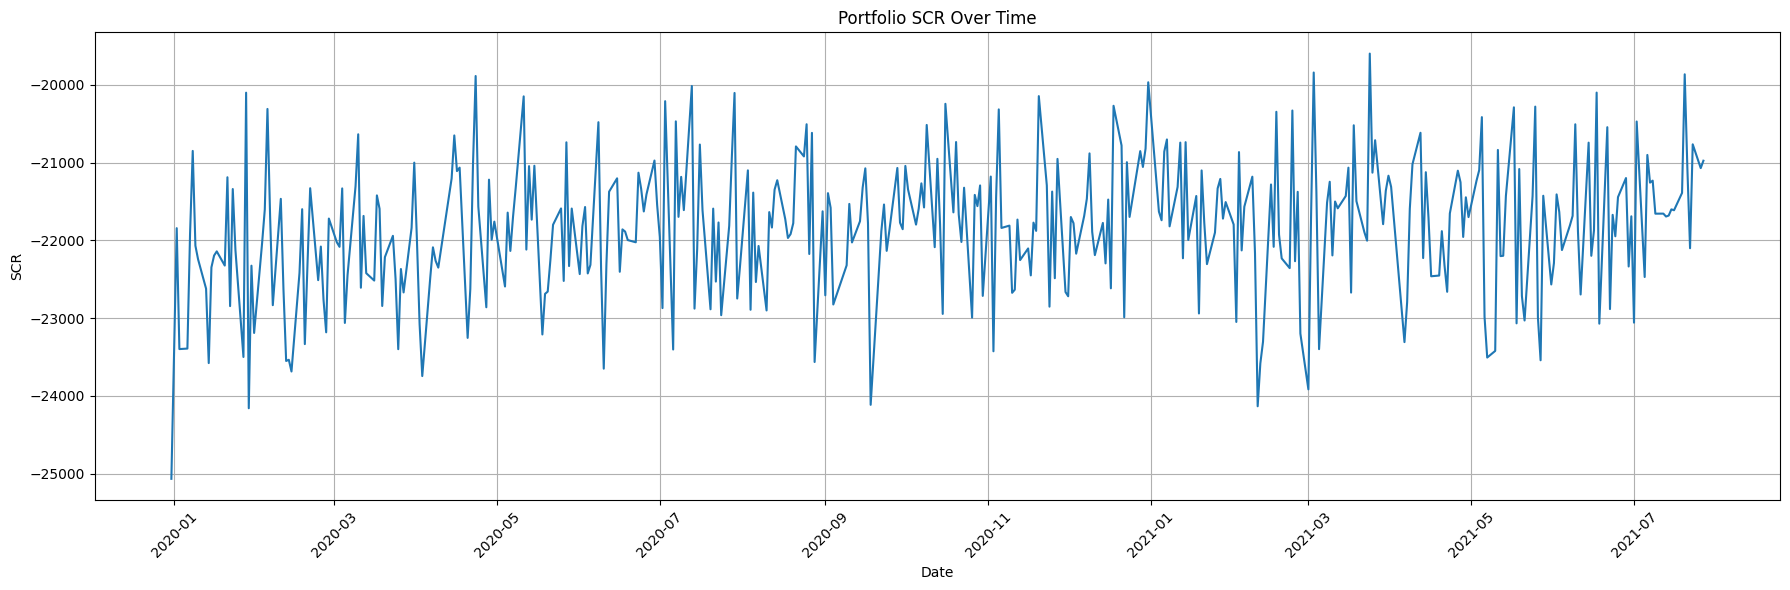

In [ ]:
# Assume portfolio_scr_results is a dictionary with dates as keys and SCR values as values.
# First, sort the dates (this assumes the keys are either datetime objects or strings that sort chronologically)
sorted_dates = sorted(portfolio_scr_results.keys())
scr_values = [portfolio_scr_results[date] for date in sorted_dates]

plt.figure(figsize=(18, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("SCR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Try out exponential weighting.

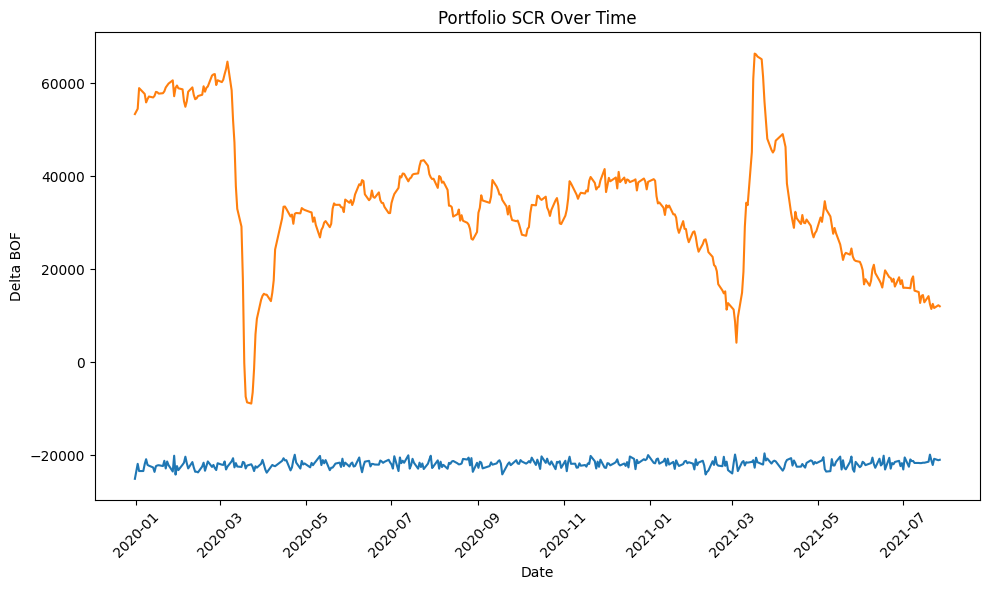

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.plot(rolling_delta_bof.index, rolling_delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Delta BOF")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

## RESULTS

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_IG_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_CGAN_output_test\generated_returns_EONIA_final_scenarios.pt
Scaled = False


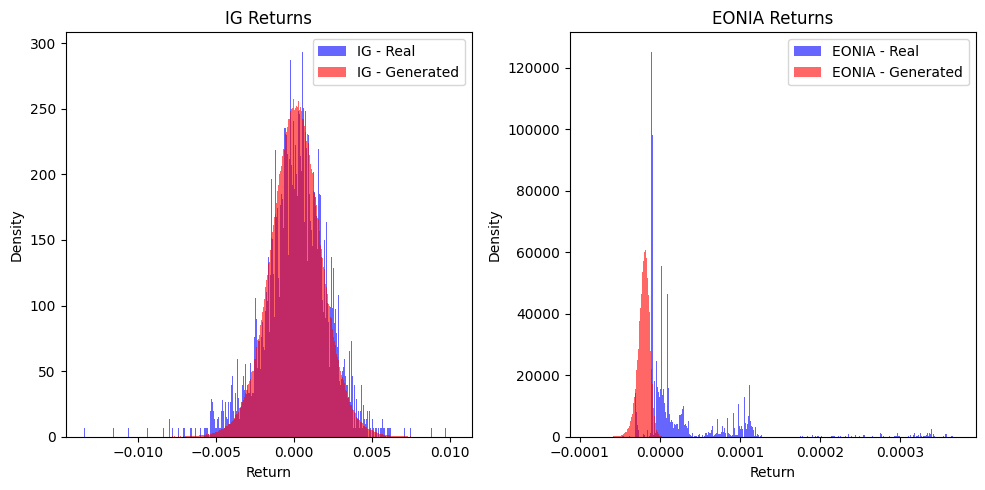


📊 Return Statistics Summary:
            Asset      Mean  Std Dev  Skewness  Kurtosis  99.5% VaR
        IG - Real  0.000182 0.002083 -0.458256  2.226597  -0.006788
   IG - Generated  0.000160 0.001670 -0.017075  0.561583  -0.004486
     EONIA - Real  0.000032 0.000069  2.682698  8.158064  -0.000031
EONIA - Generated -0.000020 0.000007 -0.667950  1.365160  -0.000044



═════════════════════════
║  ANALYZING ASSET: IG  ║
═════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_IG_final_scenarios.pt
Variance of Real Data: 0.000004
Variance of Generated Data: 0.000002
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.046002
Mean Pairwise Distance (Generated): 0.033203
✅ Generated samples are reasonably diverse


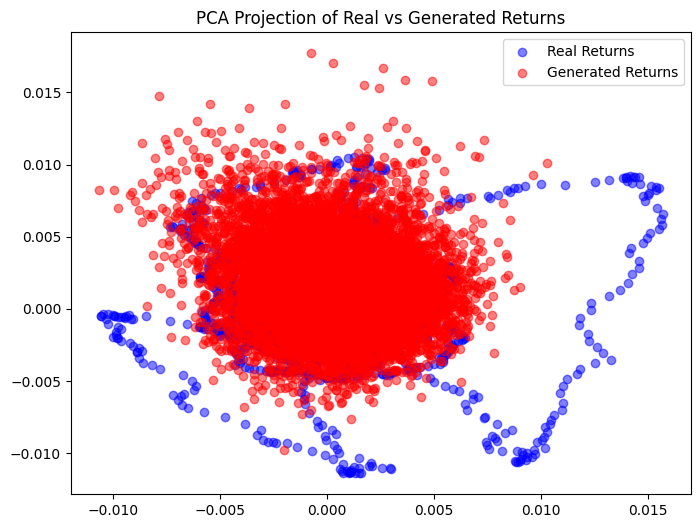

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_IG_final_scenarios.pt


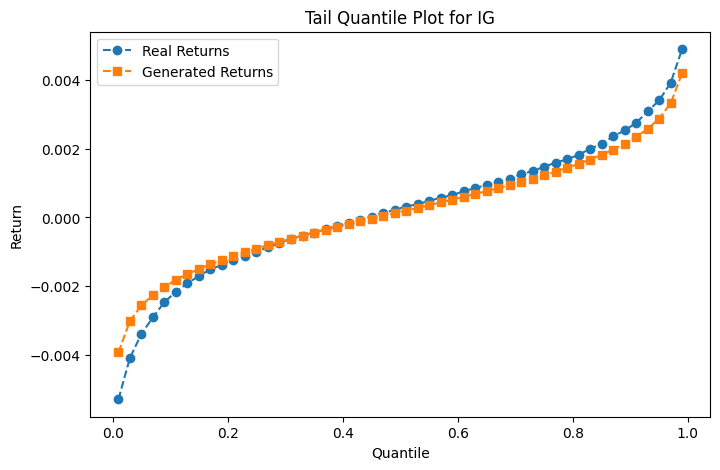


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: IG  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_IG_final_scenarios.pt

📊 Distance Summary for IG:
Min Distance: 0.000000
Max Distance: 2.230082
Mean Distance: 0.001266
Median Distance: 0.000375
Standard Deviation: 0.007740


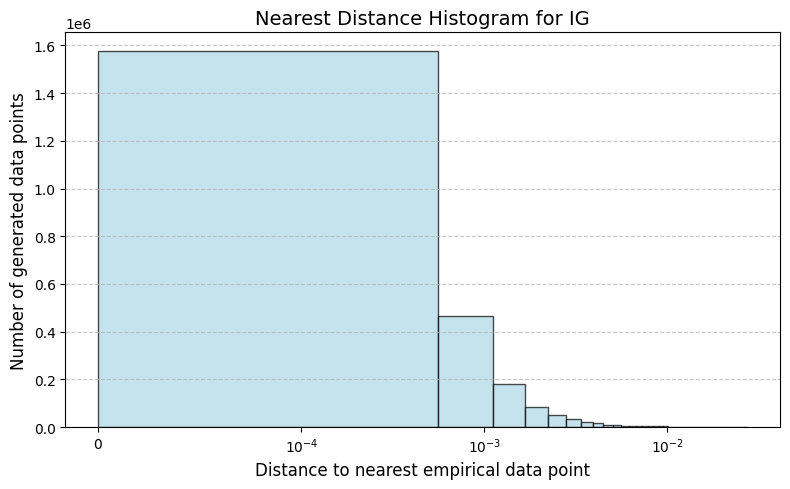


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: IG  ║
════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_IG_final_scenarios.pt
📊 Wasserstein Distance for IG: 0.000277


════════════════════════════
║  ANALYZING ASSET: EONIA  ║
════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_EONIA_final_scenarios.pt
Variance of Real Data: 0.000000
Variance of Generated Data: 0.000000
⚠️ Warning: Possible Mode Collapse - Low Variance in Generated Data
Mean Pairwise Distance (Real): 0.001171
Mean Pairwise Distance (Generated): 0.000150
⚠️ Warning: Potential Mode Collapse - Samples are too similar


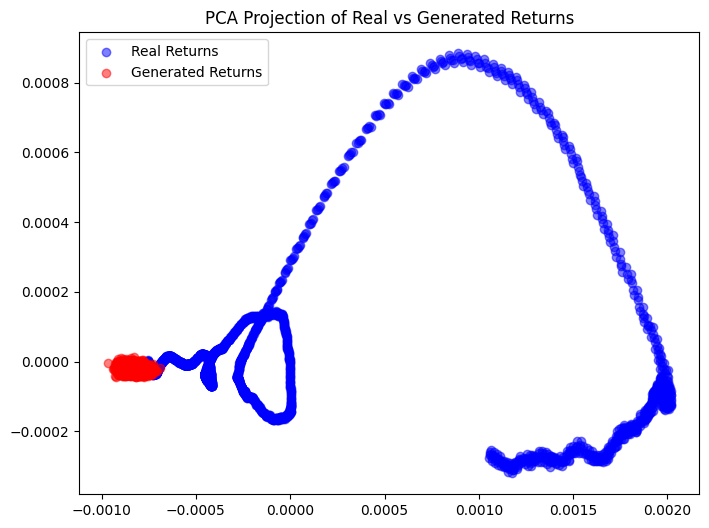


═══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: EONIA  ║
═══════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_EONIA_final_scenarios.pt
📊 Wasserstein Distance for EONIA: 0.000052



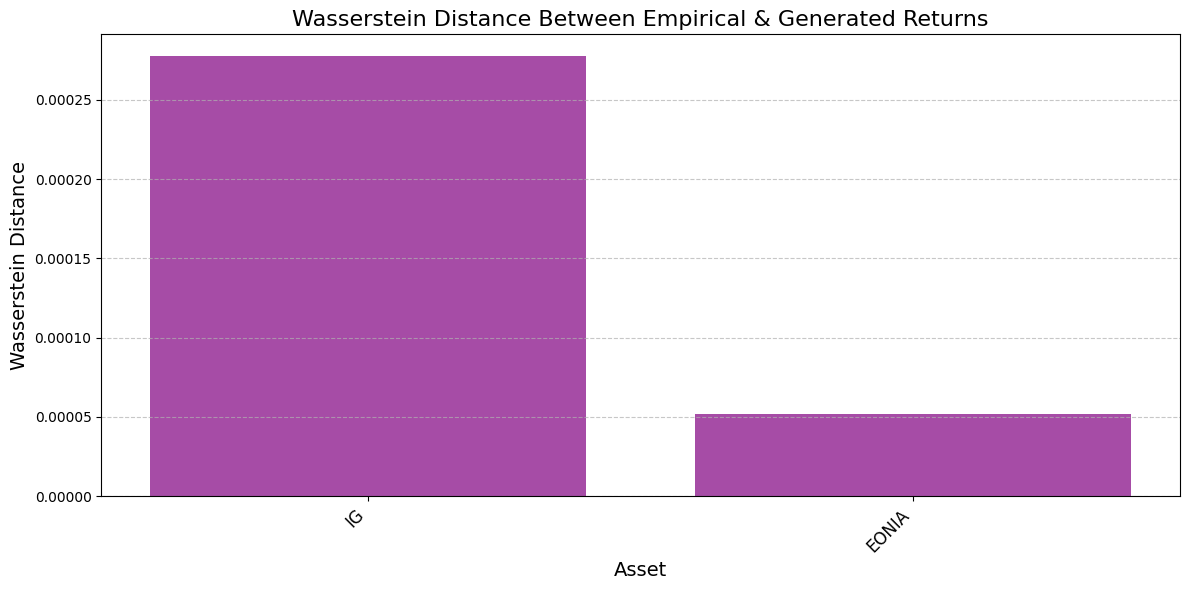

In [ ]:
extensive_plotting(scaled=False, returns_df=returns_df, test=True, quarterly=False)

# ----------------------------------------------------------

In [ ]:
from internal_models.GANs.explainability.visuals_3 import *
from internal_models.GANs.explainability.gan_visuals import *

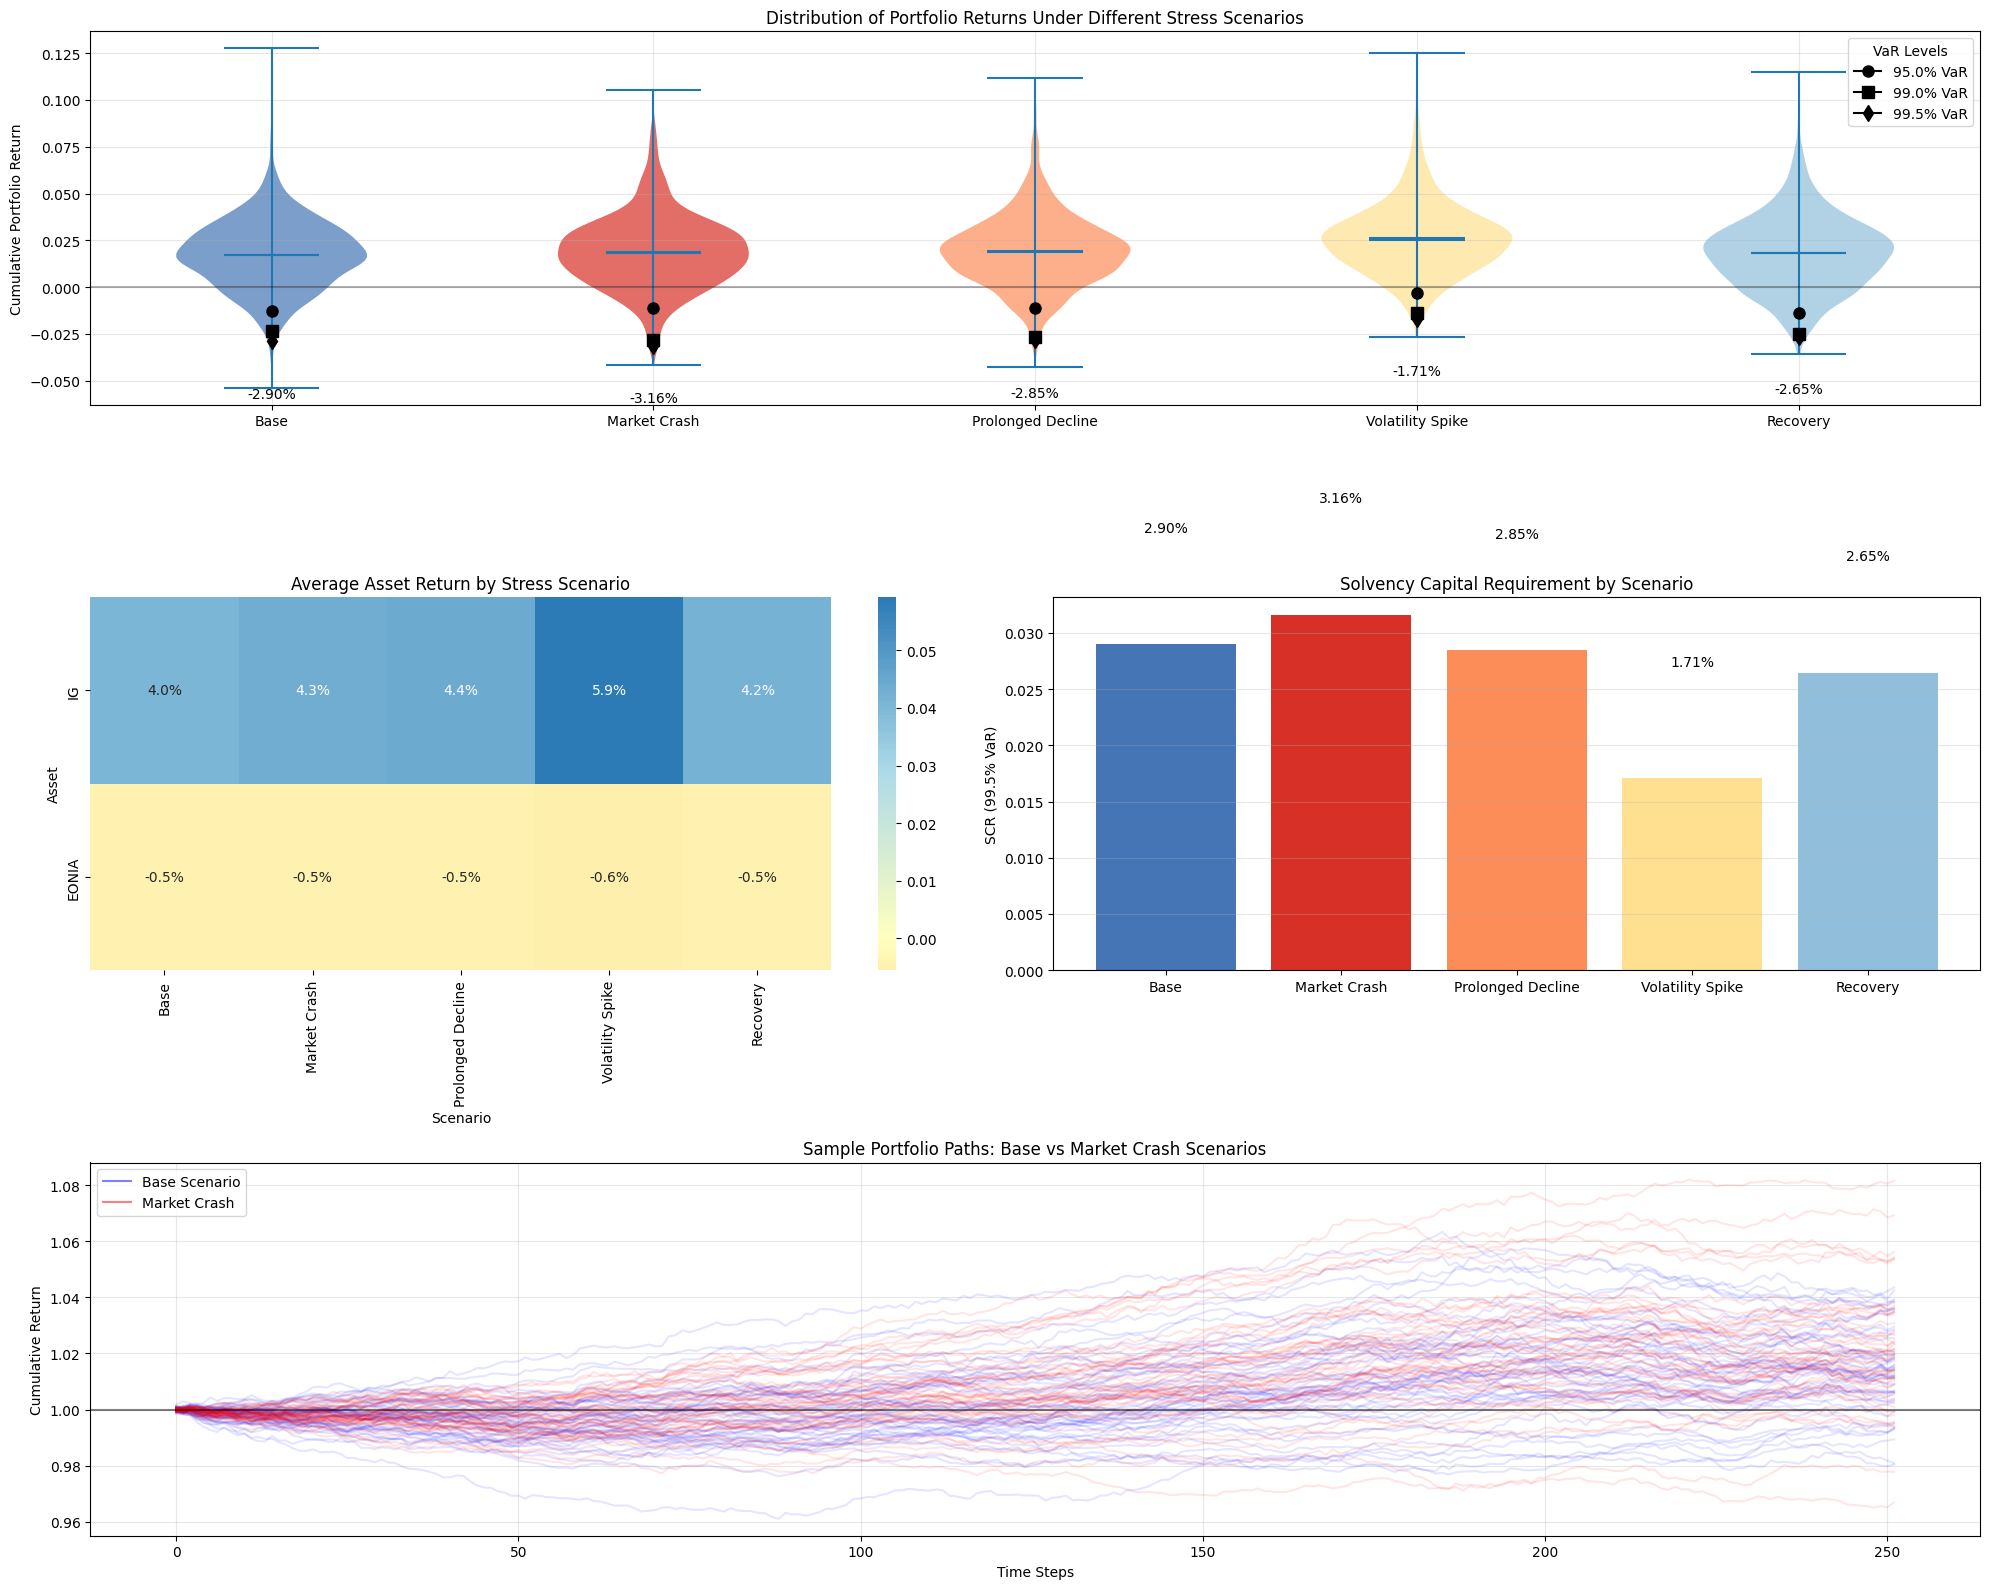

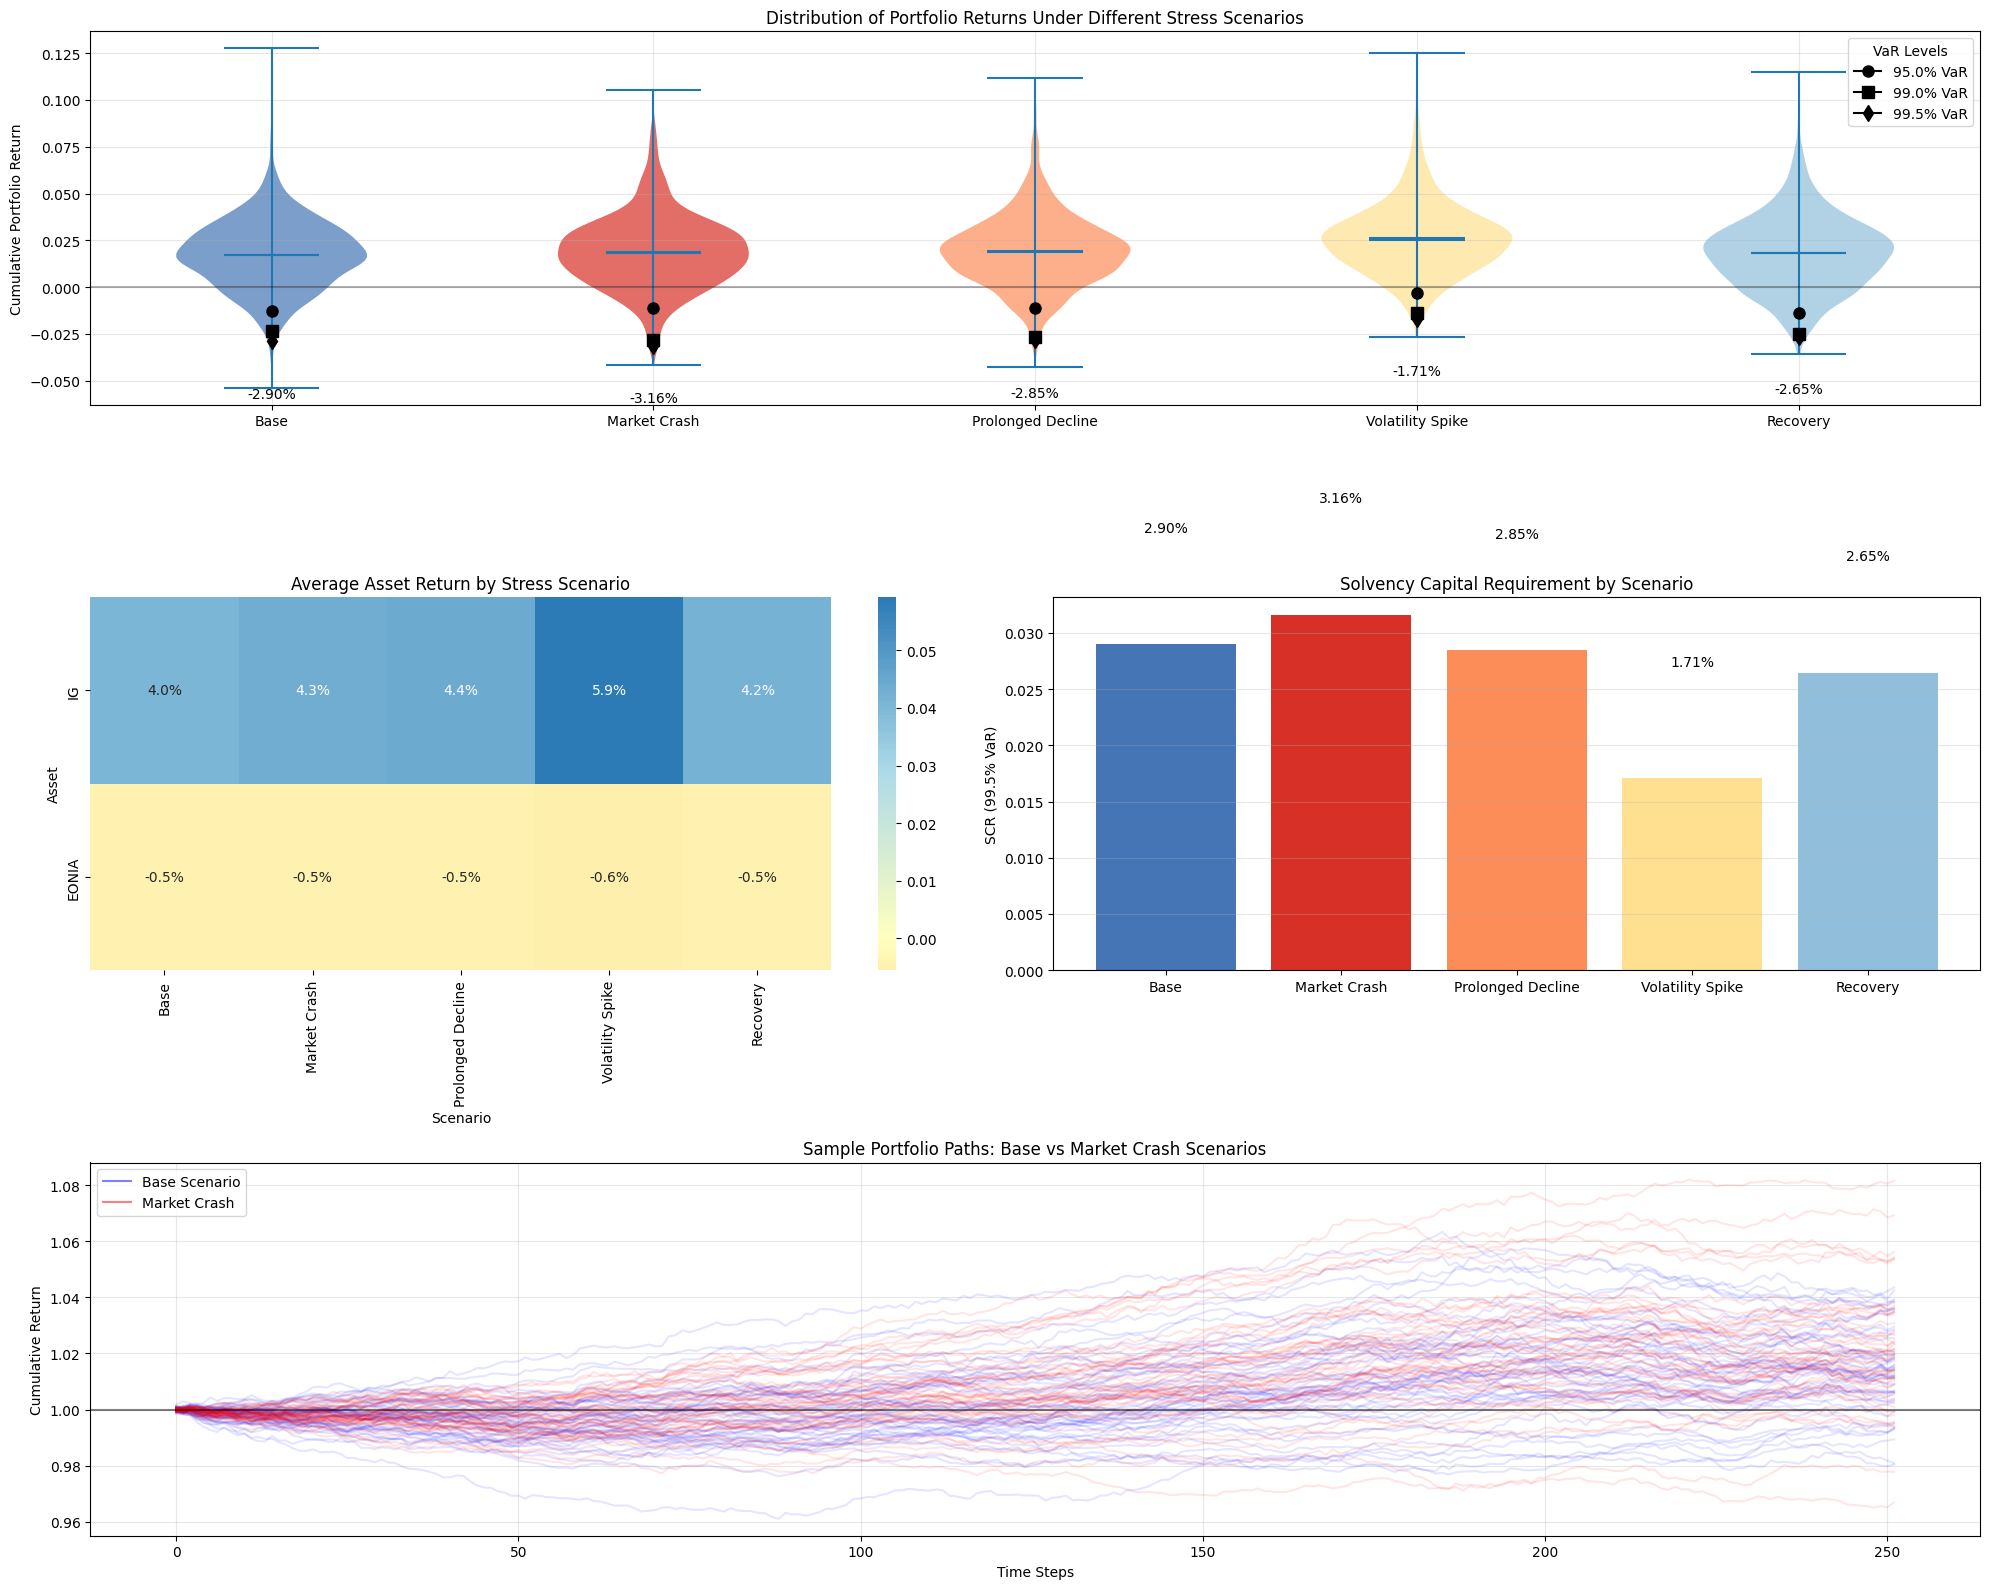

In [ ]:
visualize_stress_tests(gan_dict)

Generating latent samples...
Applying t-SNE to 2000 latent vectors...


c:\Users\nicka\master-thesis\packages\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


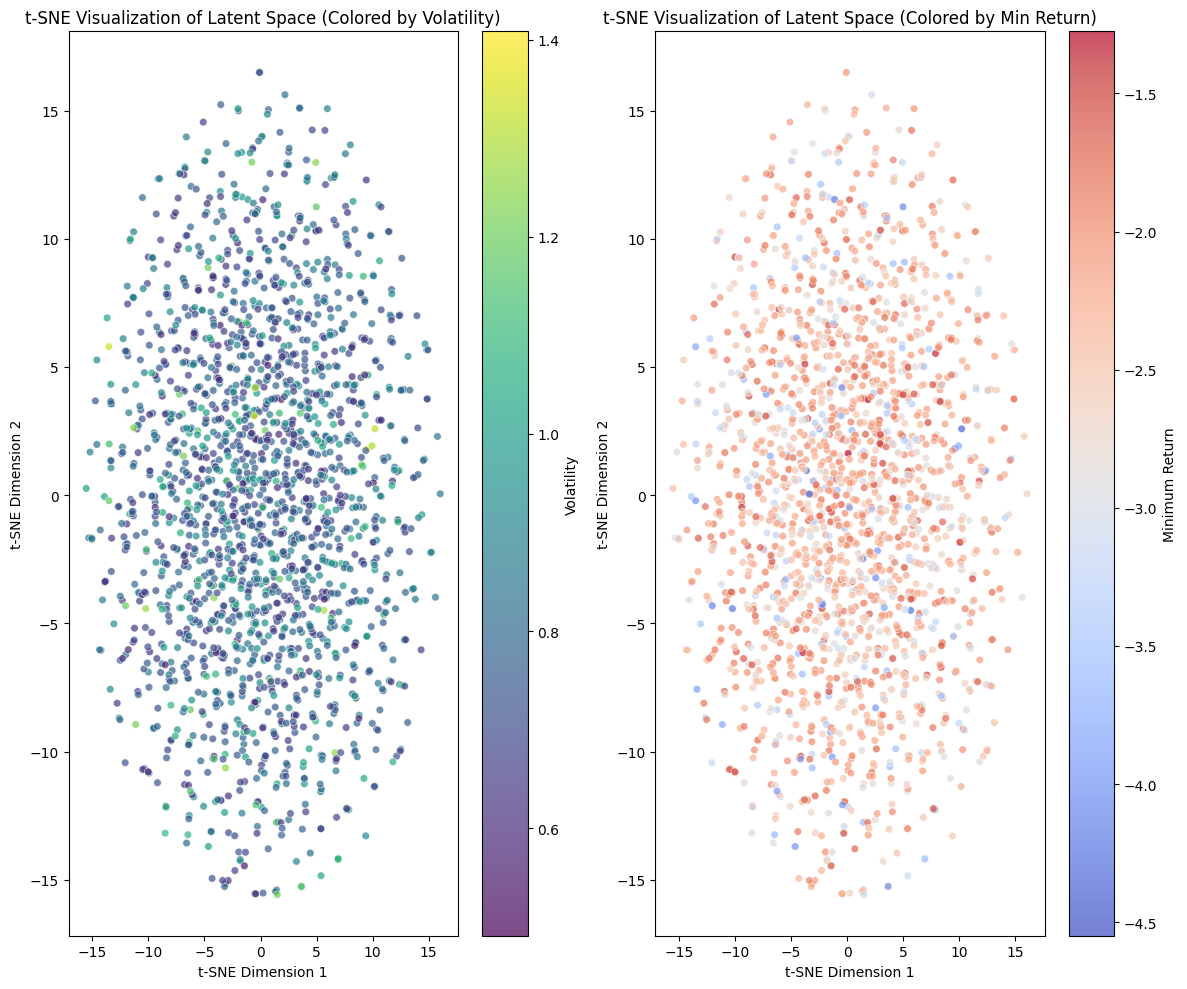

Generating latent samples...
Applying PCA to latent vectors...
Variance explained by first 3 PCs: 2.51%


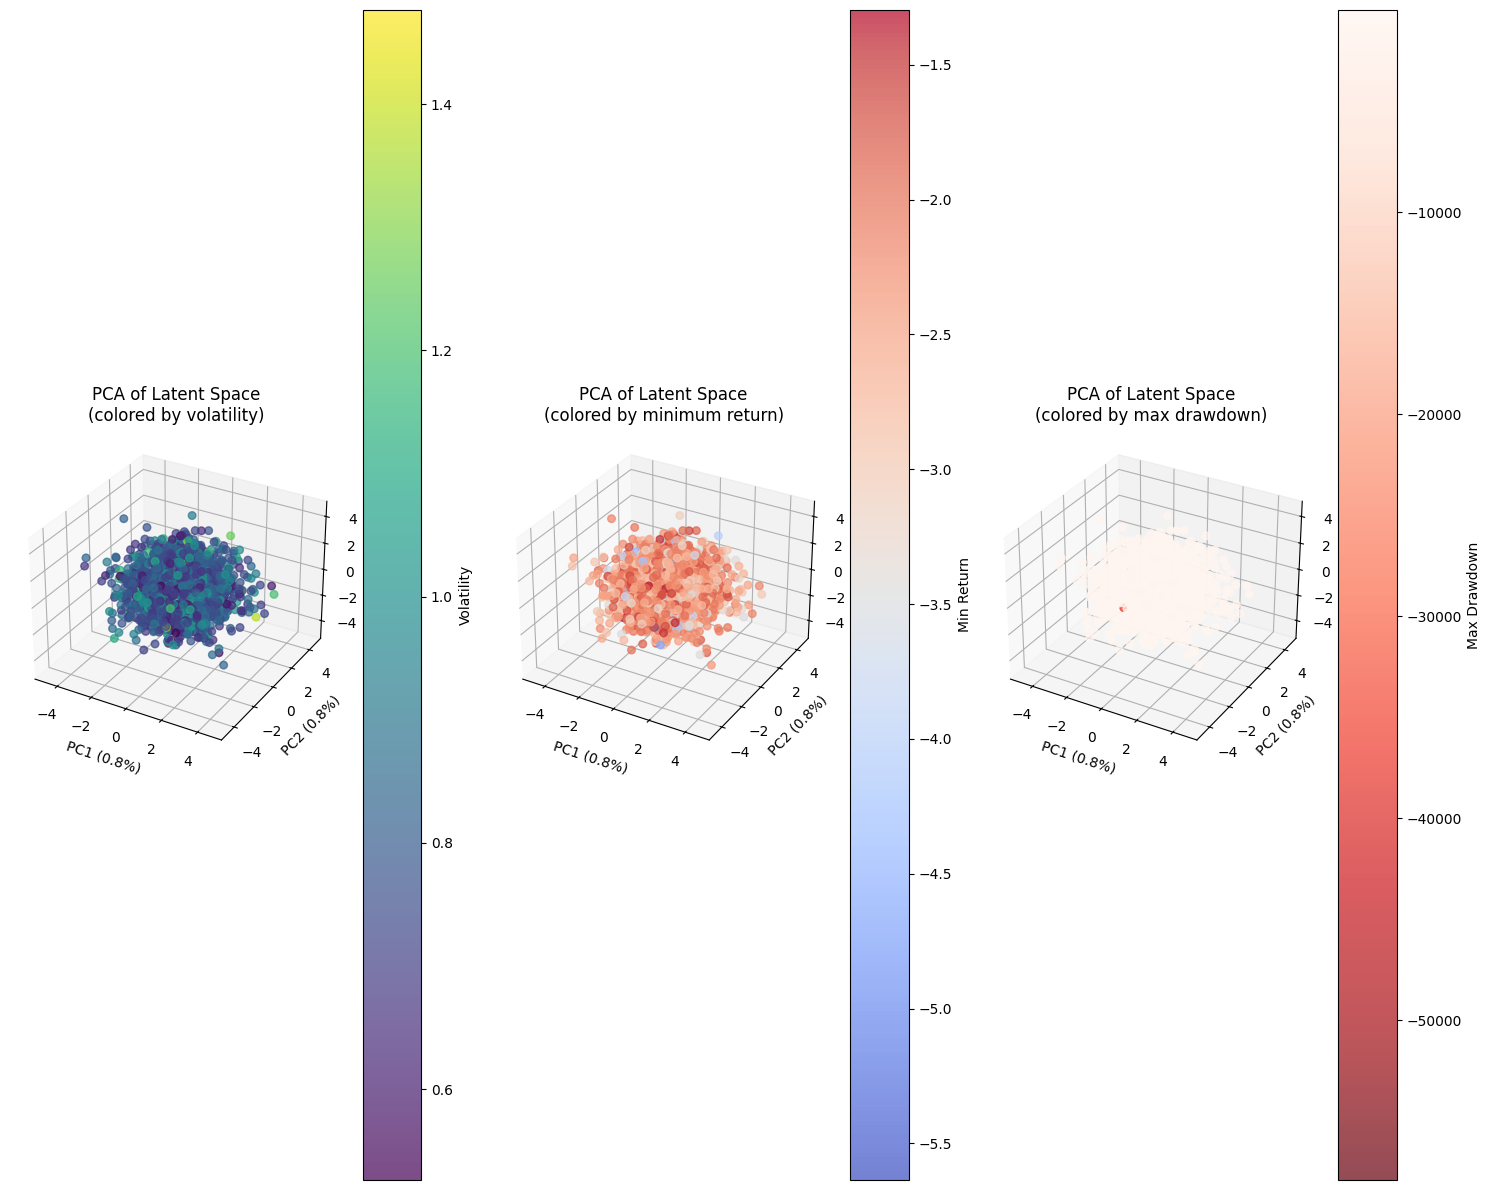

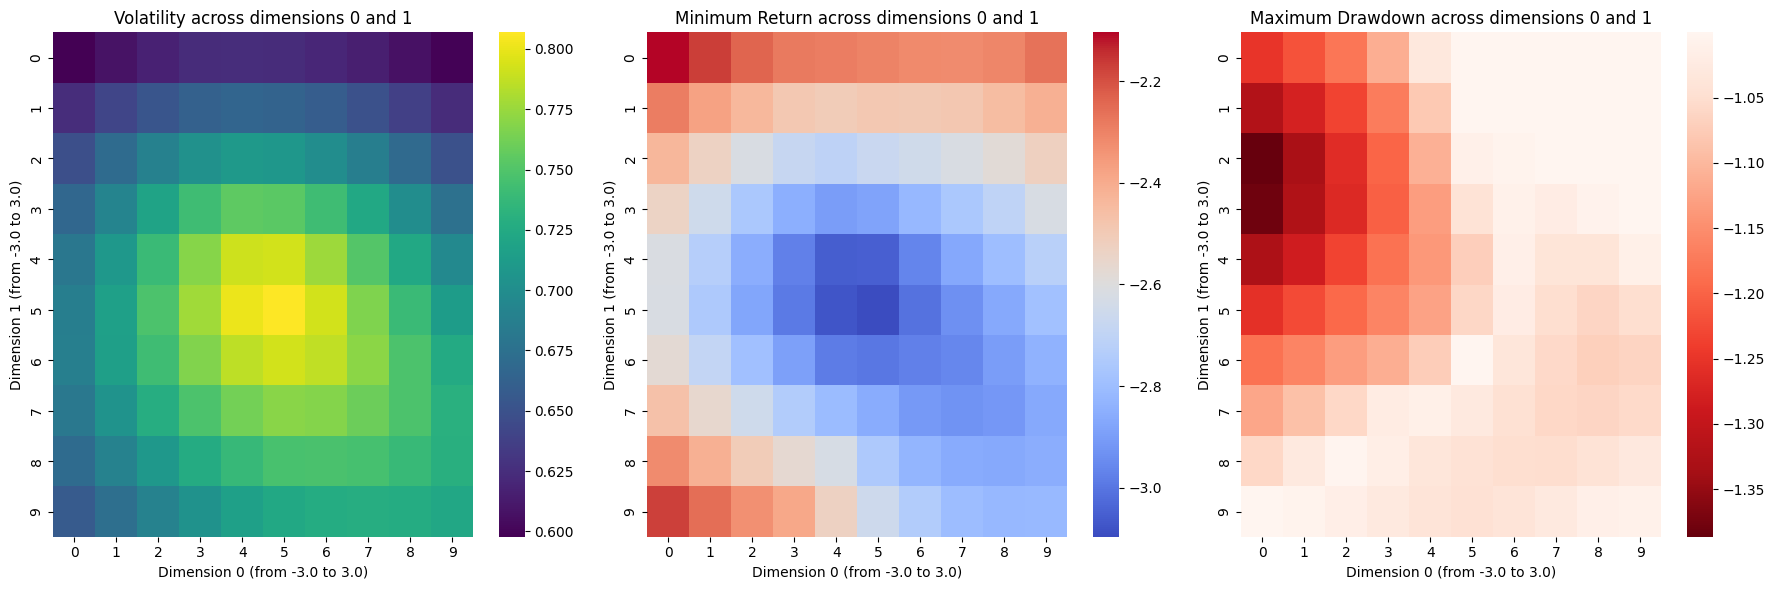

Analyzing latent components: 100%|██████████| 10/10 [00:01<00:00,  7.11it/s]


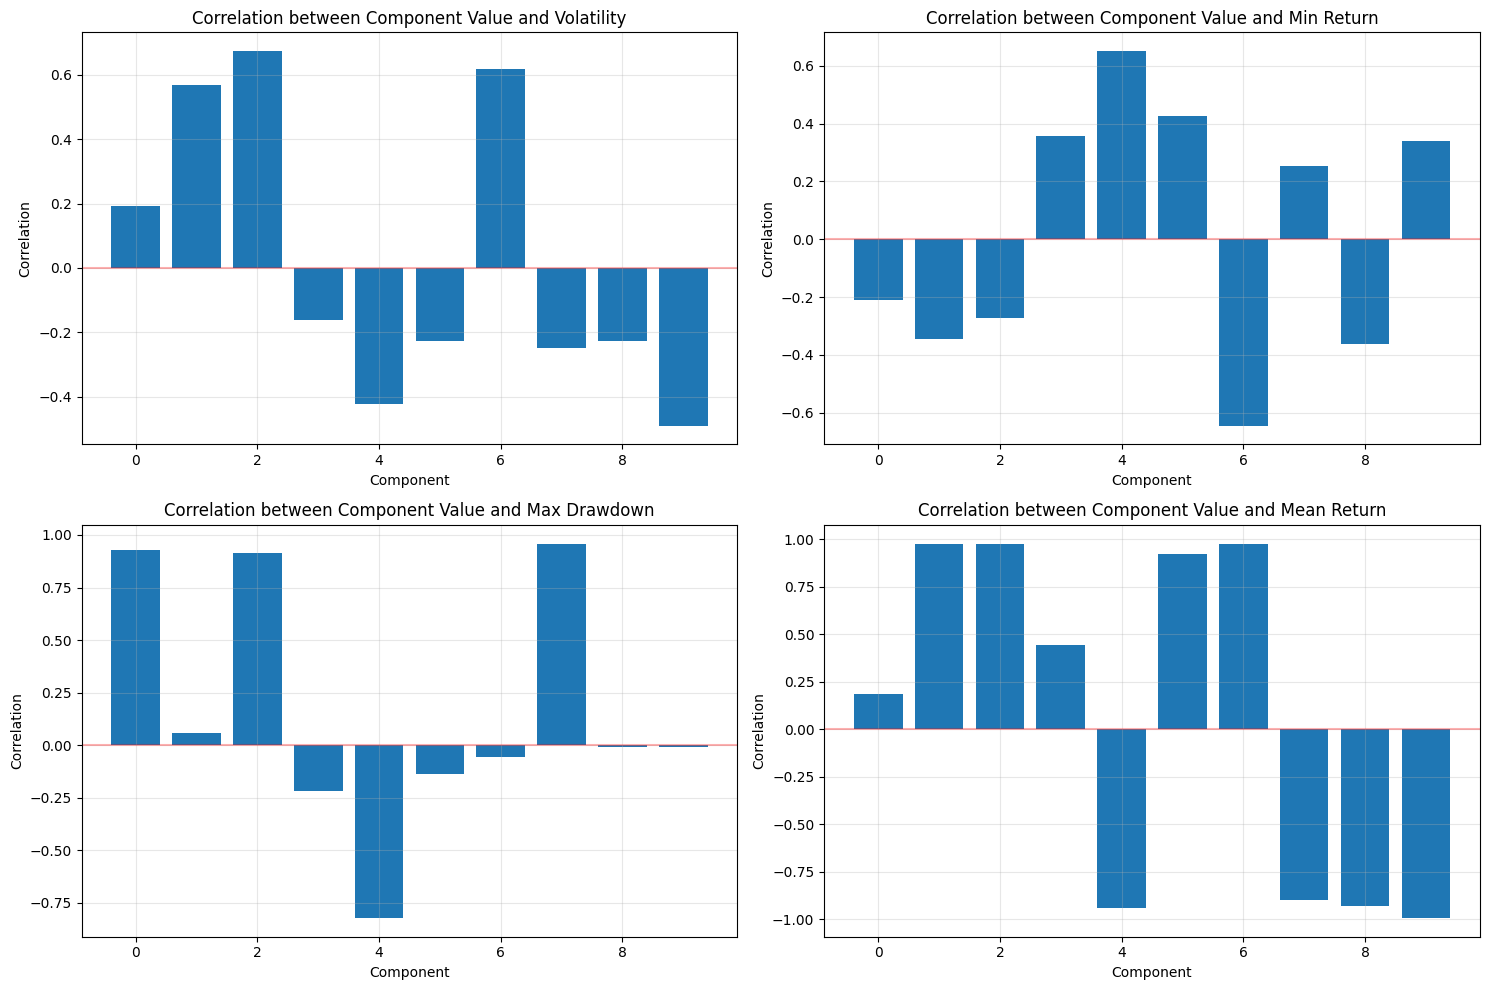

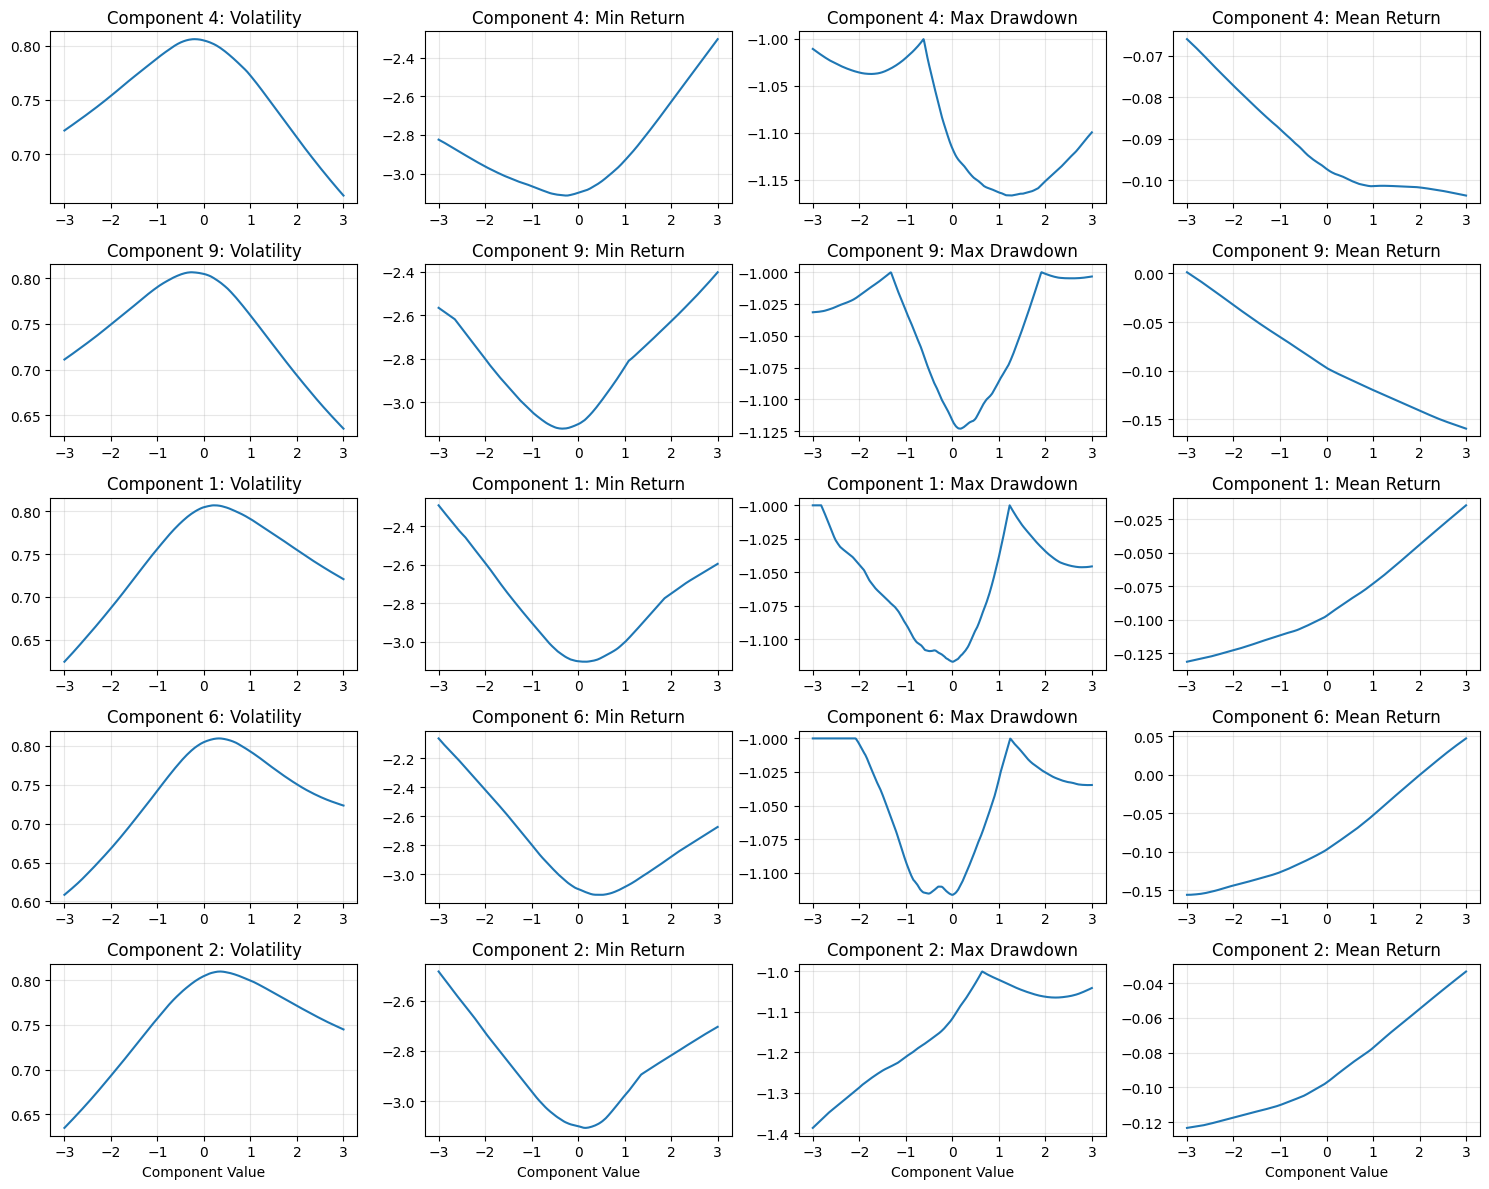

Generating latent samples...
Applying t-SNE to 2000 latent vectors...


c:\Users\nicka\master-thesis\packages\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


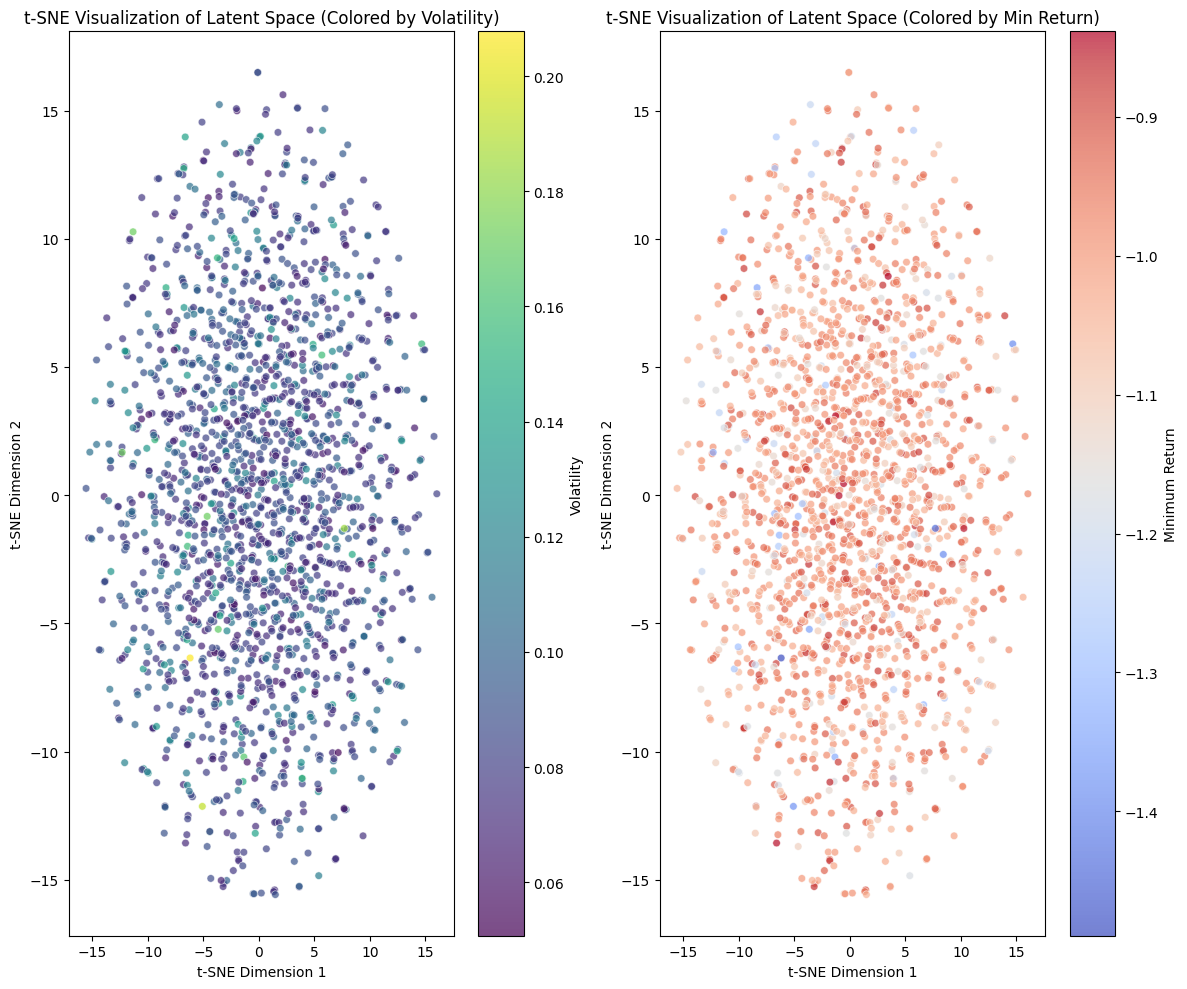

Generating latent samples...
Applying PCA to latent vectors...
Variance explained by first 3 PCs: 2.51%


c:\Users\nicka\master-thesis\internal_models\GANs\explainability\LatentSpaceVisualizer.py:175: RuntimeWarning: invalid value encountered in divide
  drawdowns = (cum_returns - running_max) / running_max


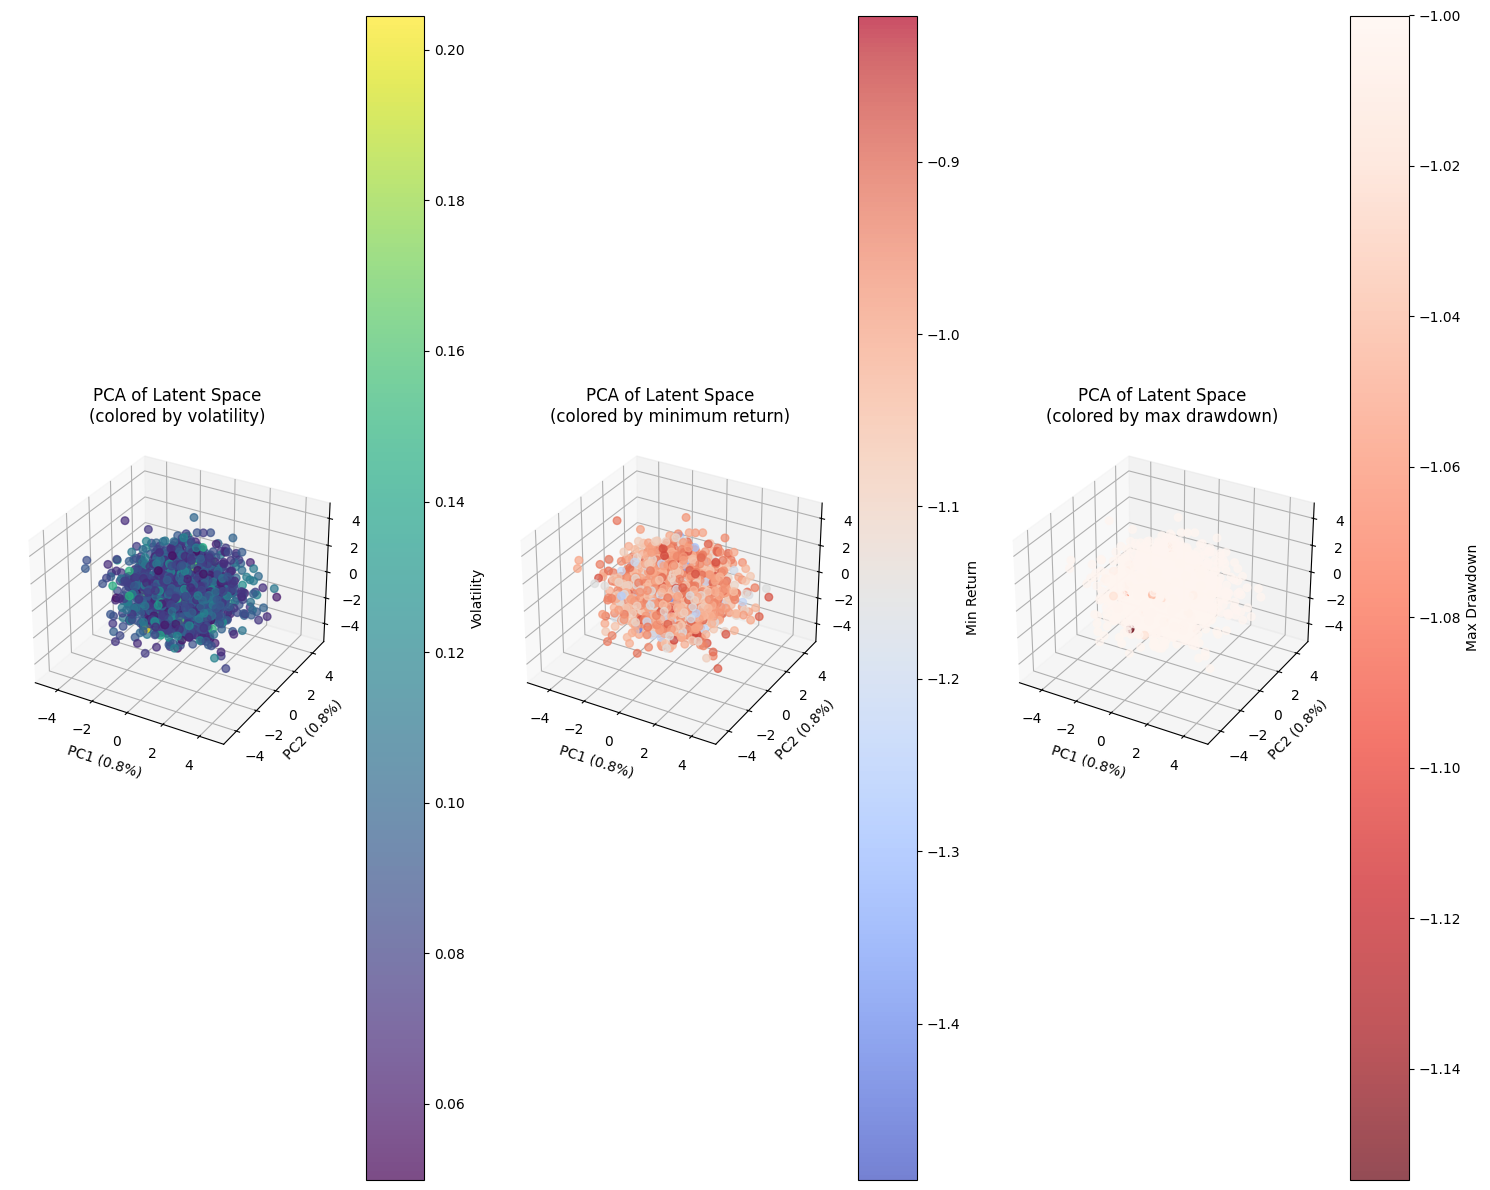

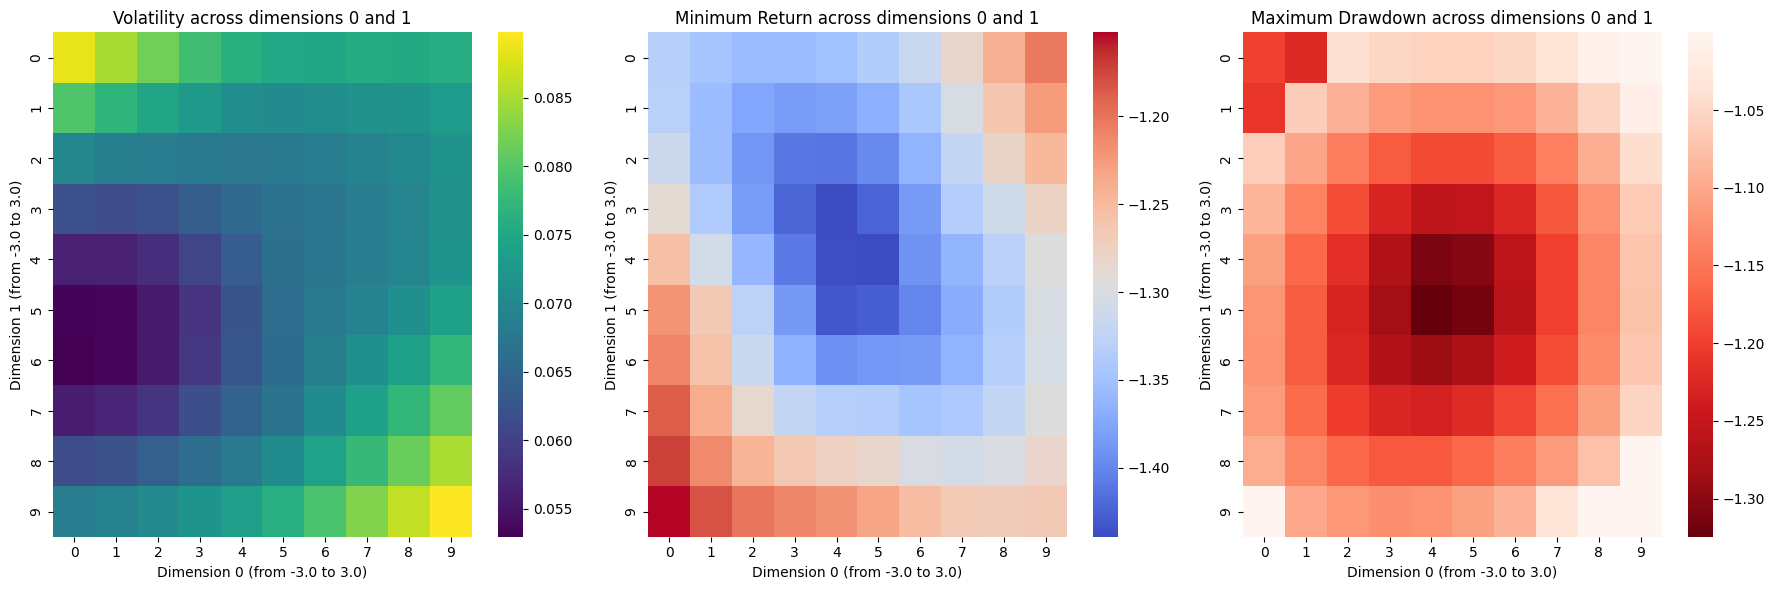

Analyzing latent components: 100%|██████████| 10/10 [00:01<00:00,  7.08it/s]


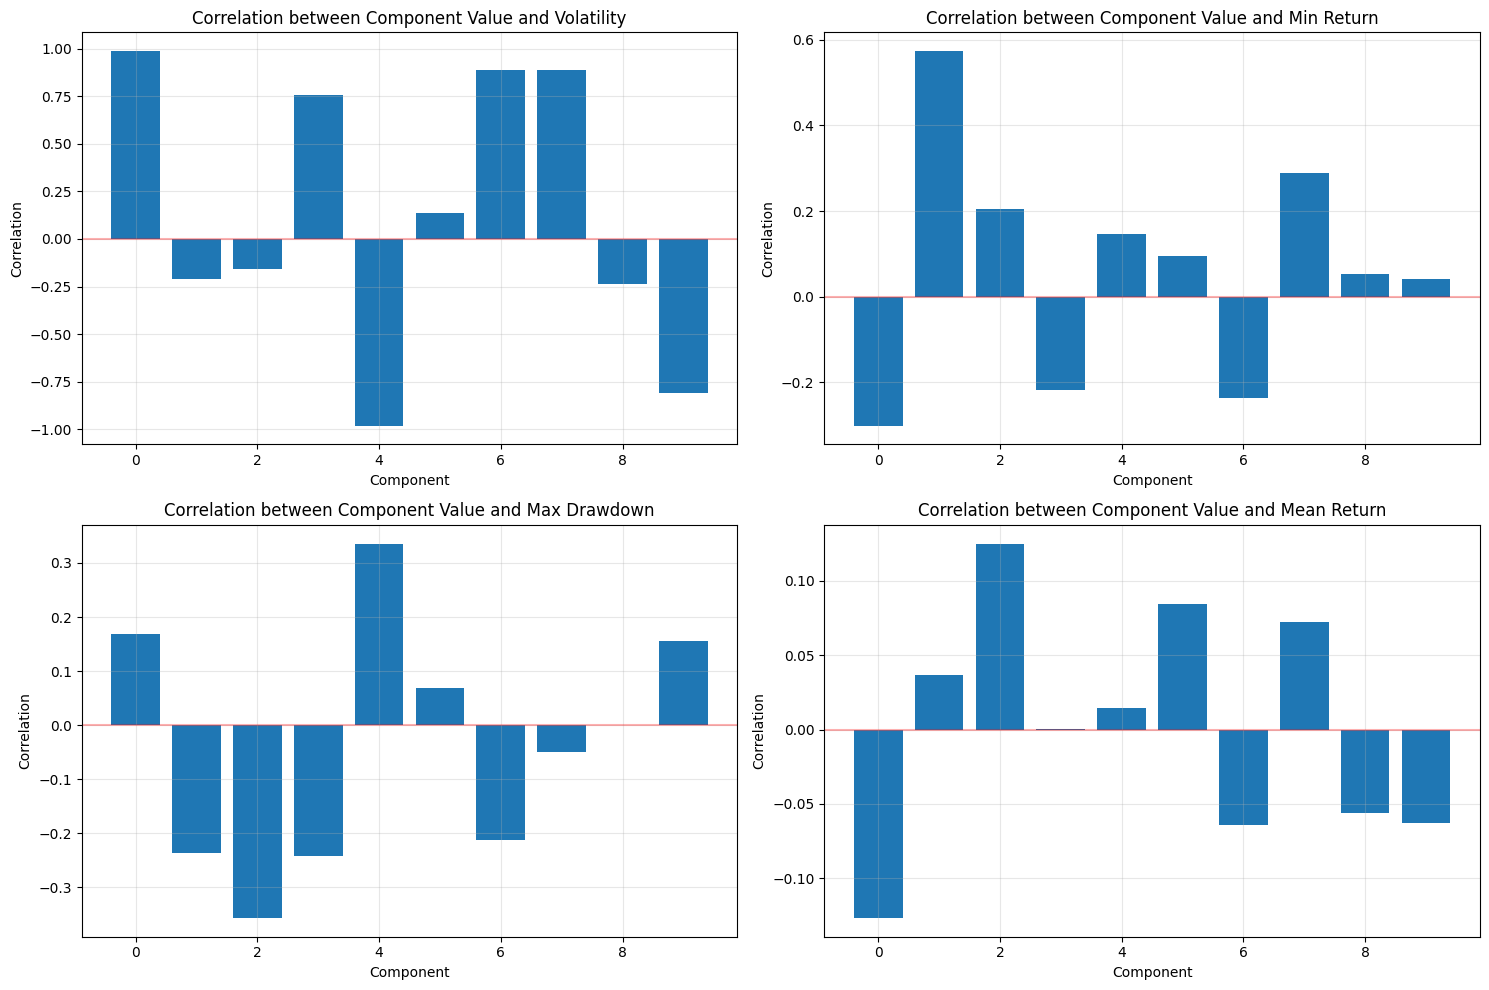

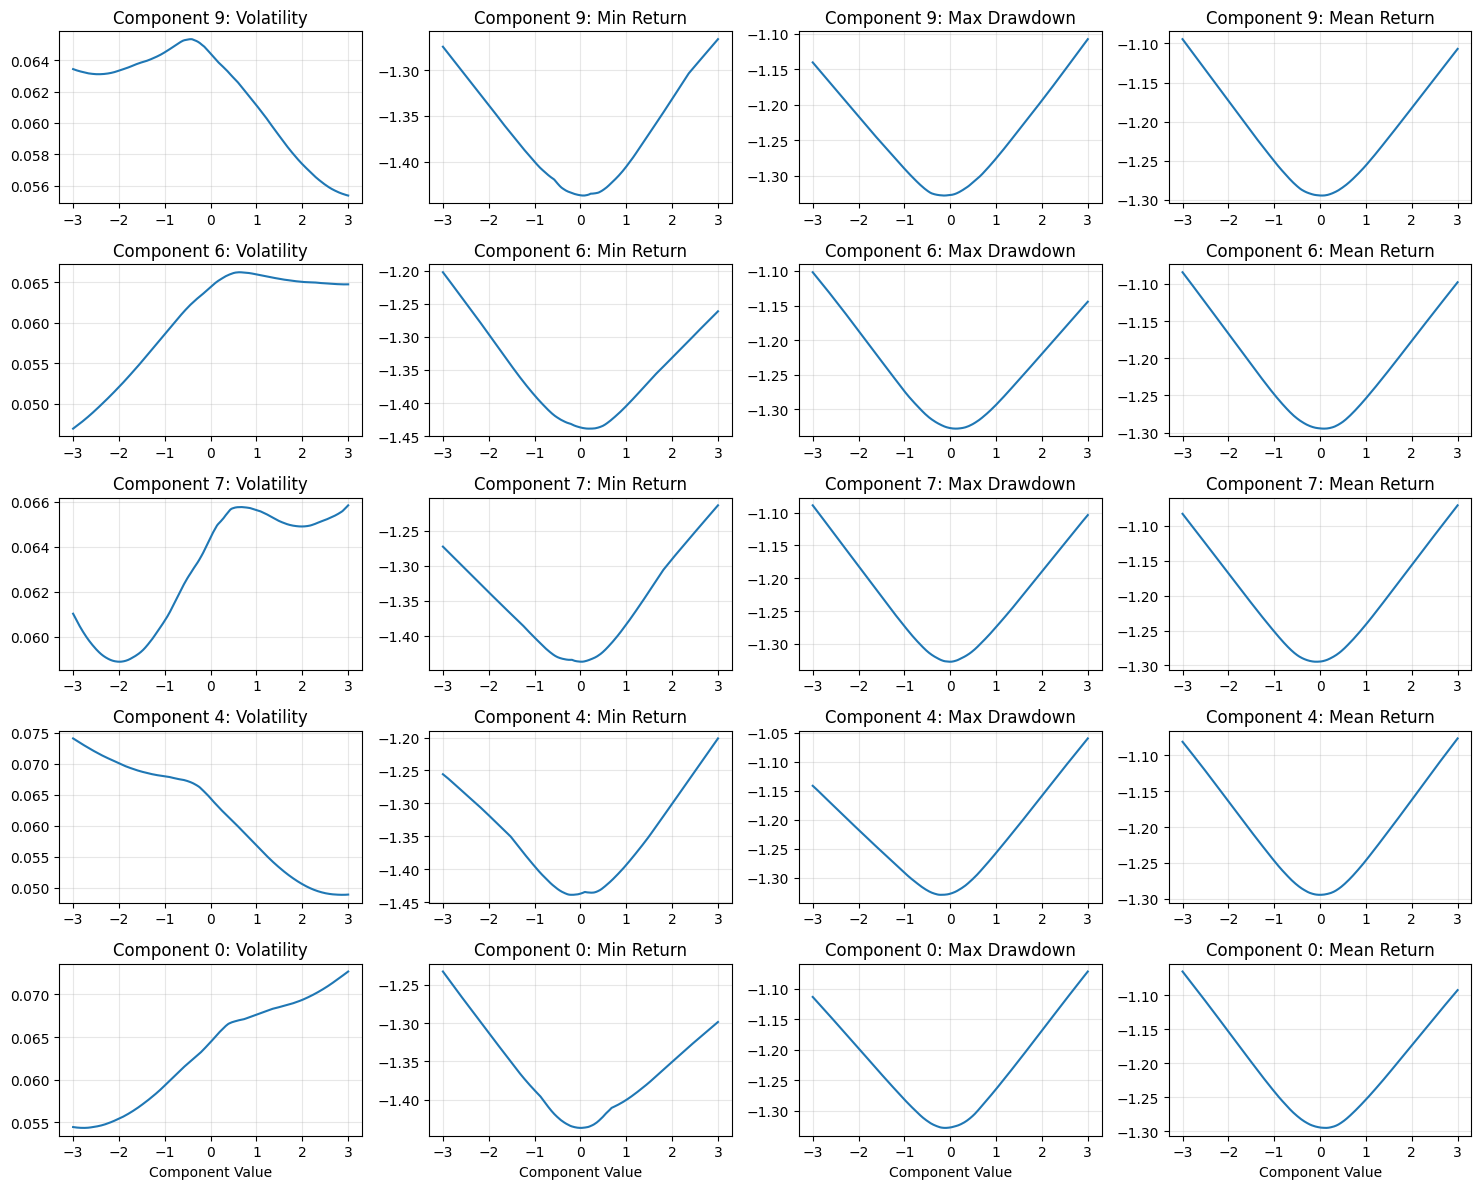

In [ ]:
from internal_models.GANs.explainability.LatentSpaceVisualizer import LatentSpaceVisualizer


for asset_name in gan_dict:
    gan = gan_dict[asset_name]
    #gen_returns = scenarios_results[asset_name]['scenarios_results']

    #explore_latent_space(gan, asset_name)
    #plot_tail_comparison(real_returns, gen_returns)
    # Create the visualizer
    visualizer = LatentSpaceVisualizer(gan, n_samples=2000)

    # Use t-SNE to visualize the latent space
    z_samples, z_tsne, gen_samples = visualizer.visualize_with_tsne(perplexity=30)

    # Use PCA to visualize the latent space in 3D
    z_samples, z_pca, gen_samples = visualizer.visualize_with_pca()

    # Analyze how traversing specific dimensions affects the output
    samples, vol, min_ret, max_dd = visualizer.latent_space_traversal(n_steps=10, dim1=0, dim2=1)

    # Analyze how individual latent dimensions affect the output
    metrics_df, correlations = visualizer.latent_component_analysis(n_components=10)
    

